# Credit Card Fraud Detection

**(This is a solution to one of the tasks I took during my internship @CODSOFT)**

_In this notebook, I attempt to create a machine learning model to detect fraudulent credit card transactions. Use a dataset containing information about credit card transactions, and experiment with algorithms like Logistic Regression, Decision Trees, or Random Forests to classify transactions as fraudulent or legitimate._

## Simulated Credit Card Fraud Detection Dataset
The simulated credit card dataset can be found on the [Kaggle-website](https://www.kaggle.com/datasets/kartik2112/fraud-detection/data). It is a simulated credit card transaction dataset containing legitimate and fraud transactions from the duration 1st Jan 2019 - 31st Dec 2020. It covers credit cards of 1000 customers doing transactions with a pool of 800 merchants.

In [35]:
# Load packages
import time
import numpy as np 
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
# estimators and utilities
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import AdaBoostClassifier
# preprocess & engineering
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
# model scoring and validation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc

## Load your data

In [36]:
# Upload data as a .csv file 
df = pd.read_csv('fraudTrain.csv', index_col=0)
df.head()


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [37]:
df.shape

(1296675, 22)

The dataset set is obviusly a large, with about 1.2 observations and 22 features. It is going to require a bit of computing power to train such a large dataset. There are some redundant features that will be ignored, for example, I don't need a city or state, if i have the longitude and latitude

## Data types distribution

In [38]:
print(df.dtypes)
print(df.dtypes.value_counts())

trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object
object     12
int64       5
float64     5
dtype: int64


More than half of the features are of object datatype which is considered an unsuitable state for the scikit-learn library. So I will later convert and encode them as appropraite. Lickily the target variable `is_fraud` is already encoded as 0 and 1

## Understand your class distribution

Understanding the distribution helps me identify potential biases, evaluate the performance of my model and avoid generalisation due to imbalanced sampling

In [39]:
is_fraud_count = df['is_fraud'].value_counts()
print(is_fraud_count)

0    1289169
1       7506
Name: is_fraud, dtype: int64


<Figure size 1500x1000 with 0 Axes>

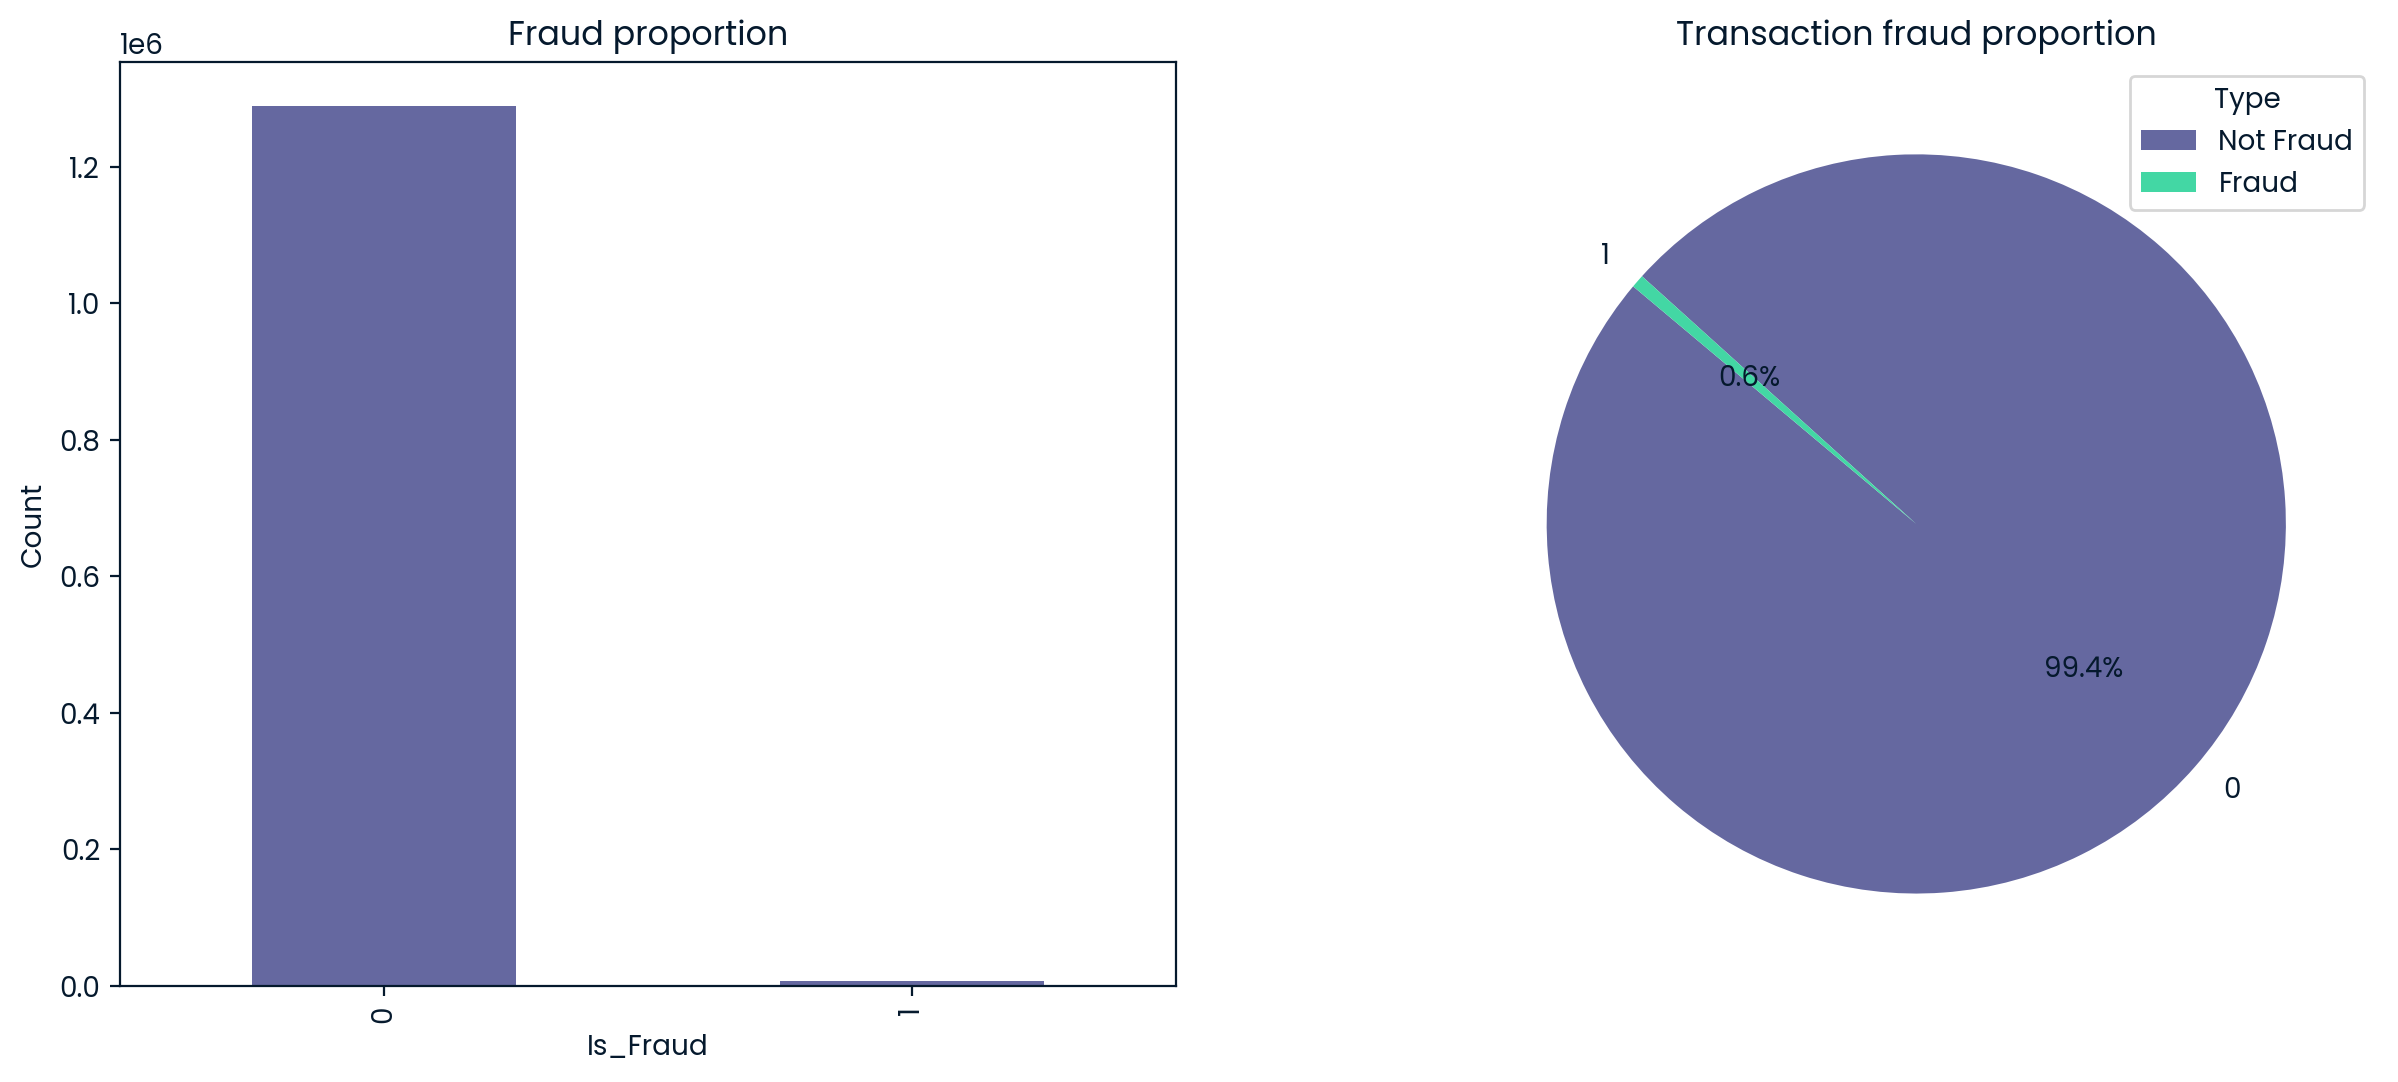

<Figure size 1500x1000 with 0 Axes>

In [40]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

is_fraud_count.plot(kind='bar', ax=ax1)
ax1.set_title("Fraud proportion")
ax1.set_xlabel("Is_Fraud")
ax1.set_ylabel("Count")

# Plot the pie chart
ax2 = plt.pie(is_fraud_count, labels=is_fraud_count.index, autopct='%1.1f%%', startangle=140)
plt.title("Transaction fraud proportion")
plt.legend(title='Type', labels=['Not Fraud', 'Fraud']);
plt.figure(figsize=(15,10))

There is a large **imbalance** in the number of instances in the two classes. This will later inform the need and approach of sampling _(UNDERSAMPLING)_ which I will employ later on.

## Exploratory Data Analysis (EDA)


The dataset is huge, we can not easily get to know it and decide how to tackle some interesting questions. From the introductory code above we know:
* `CATEGORY` is categorical variable taking 14 values
* `CITY`, `STATE` and `ZIP` are also categorical containing 894, 51 and 970 values 
* `GENDER` is binary 
* `TRANS_DATE_TRANS_TIME` and `DOB` are datetime values
* There are many are numerical continuous variables  

First of all, let's ensure there are no nulls:

In [41]:
df.isnull().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

There are no missing values in the data

In [42]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
cc_num,1296675.0,4.171920e+17,1.308806e+18,6.041621e+10,1.800429e+14,3.521417e+15,4.642255e+15,4.992346e+18
amt,1296675.0,7.035104e+01,1.603160e+02,1.000000e+00,9.650000e+00,4.752000e+01,8.314000e+01,2.894890e+04
zip,1296675.0,4.880067e+04,2.689322e+04,1.257000e+03,2.623700e+04,4.817400e+04,7.204200e+04,9.978300e+04
lat,1296675.0,3.853762e+01,5.075808e+00,2.002710e+01,3.462050e+01,3.935430e+01,4.194040e+01,6.669330e+01
long,1296675.0,-9.022634e+01,1.375908e+01,-1.656723e+02,-9.679800e+01,-8.747690e+01,-8.015800e+01,-6.795030e+01
city_pop,1296675.0,8.882444e+04,3.019564e+05,2.300000e+01,7.430000e+02,2.456000e+03,2.032800e+04,2.906700e+06
unix_time,1296675.0,1.349244e+09,1.284128e+07,1.325376e+09,1.338751e+09,1.349250e+09,1.359385e+09,1.371817e+09
merch_lat,1296675.0,3.853734e+01,5.109788e+00,1.902779e+01,3.473357e+01,3.936568e+01,4.195716e+01,6.751027e+01
merch_long,1296675.0,-9.022646e+01,1.377109e+01,-1.666712e+02,-9.689728e+01,-8.743839e+01,-8.023680e+01,-6.695090e+01
is_fraud,1296675.0,5.788652e-03,7.586269e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


In [43]:
df.describe(exclude='number').T

,count,unique,top,freq
trans_date_trans_time,1296675,1274791,2019-04-22 16:02:01,4
merchant,1296675,693,fraud_Kilback LLC,4403
category,1296675,14,gas_transport,131659
first,1296675,352,Christopher,26669
last,1296675,481,Smith,28794
gender,1296675,2,F,709863
street,1296675,983,0069 Robin Brooks Apt. 695,3123
city,1296675,894,Birmingham,5617
state,1296675,51,TX,94876
job,1296675,494,Film/video editor,9779


In [44]:
# Selecting relevant columns for visualization
columns_of_interest = ['trans_date_trans_time', 'cc_num', 'category', 'amt', 'gender', 'city', 'state', 'zip', 'city_pop', 'dob', 'is_fraud']

df_subset = pd.DataFrame(df[columns_of_interest])


<Axes.ArtistList of 6 patches>


<Figure size 1500x1000 with 0 Axes>

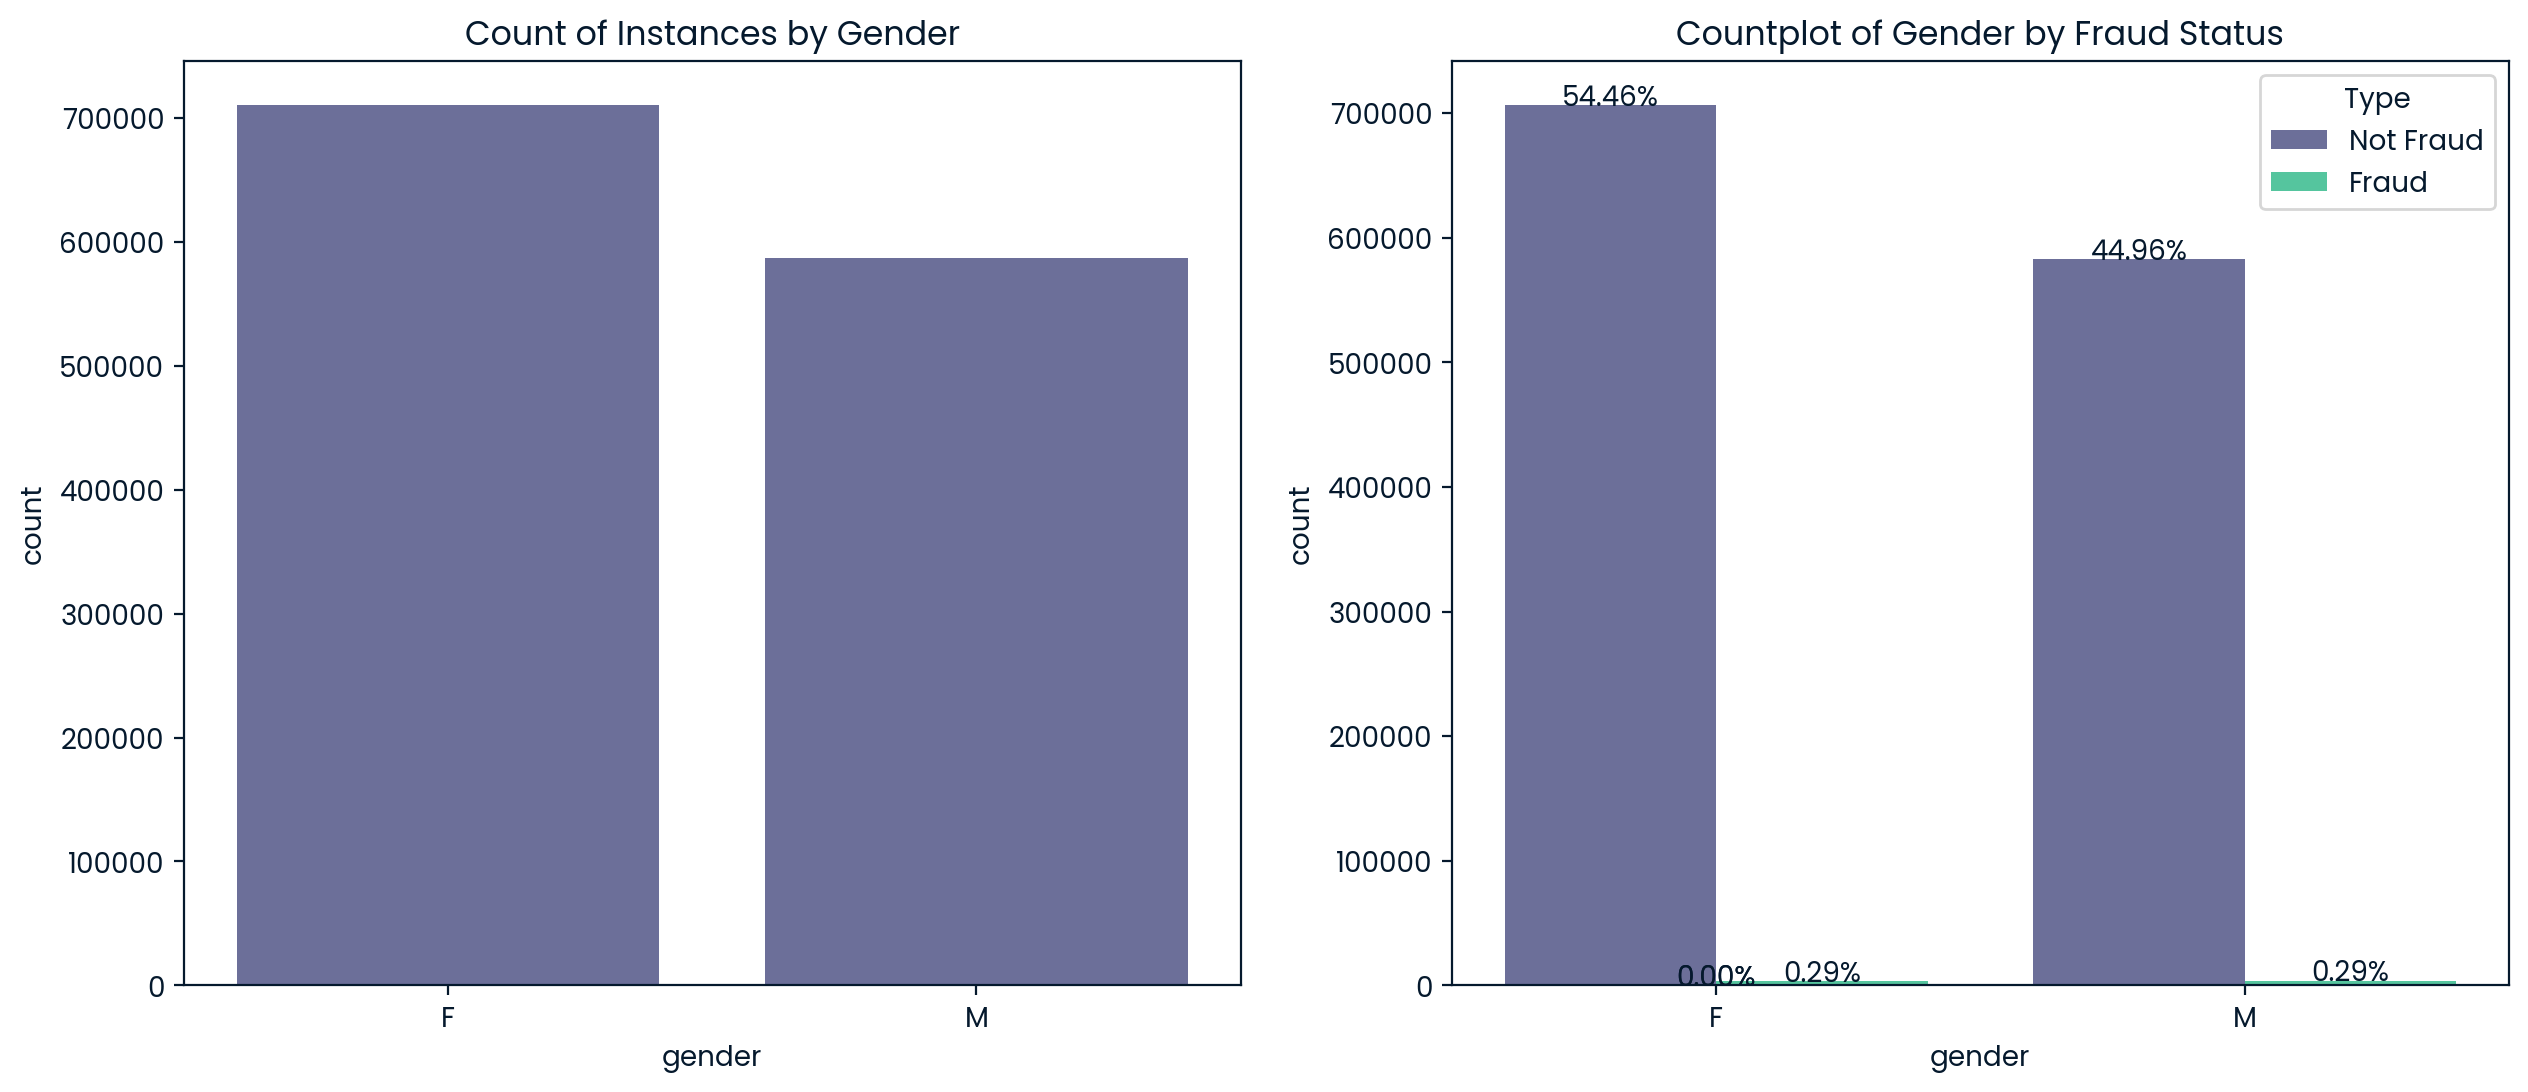

<Figure size 1500x1000 with 0 Axes>

In [45]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.countplot(data=df_subset, x='gender', ax=ax1)
ax1.set_title('Count of Instances by Gender')

# Calculate fraud rate
fraud_rate = df_subset.groupby('gender')['is_fraud'].mean()

sns.countplot(data=df_subset, x='gender', hue='is_fraud', ax=ax2)
ax2.set_title('Countplot of Gender by Fraud Status')
ax2.legend(title='Type', labels=['Not Fraud', 'Fraud'])

# Normalize the counts
total = len(df_subset)
print(ax2.patches)
for p in ax2.patches:
    height = p.get_height()
    ax2.text(p.get_x() + p.get_width() / 2.,
              height + 3,
              '{:.2f}%'.format((height / total) * 100),
              ha="center")

plt.legend(title='Type', labels=['Not Fraud', 'Fraud']);
plt.figure(figsize=(15,10))

Although the `gender` feature appears to be also even distribiuted between the 2 values but the class imbalance of the target variable `is_fraud` in the dataset can be seen in the gender feature of the dataset

<Figure size 1500x1000 with 0 Axes>

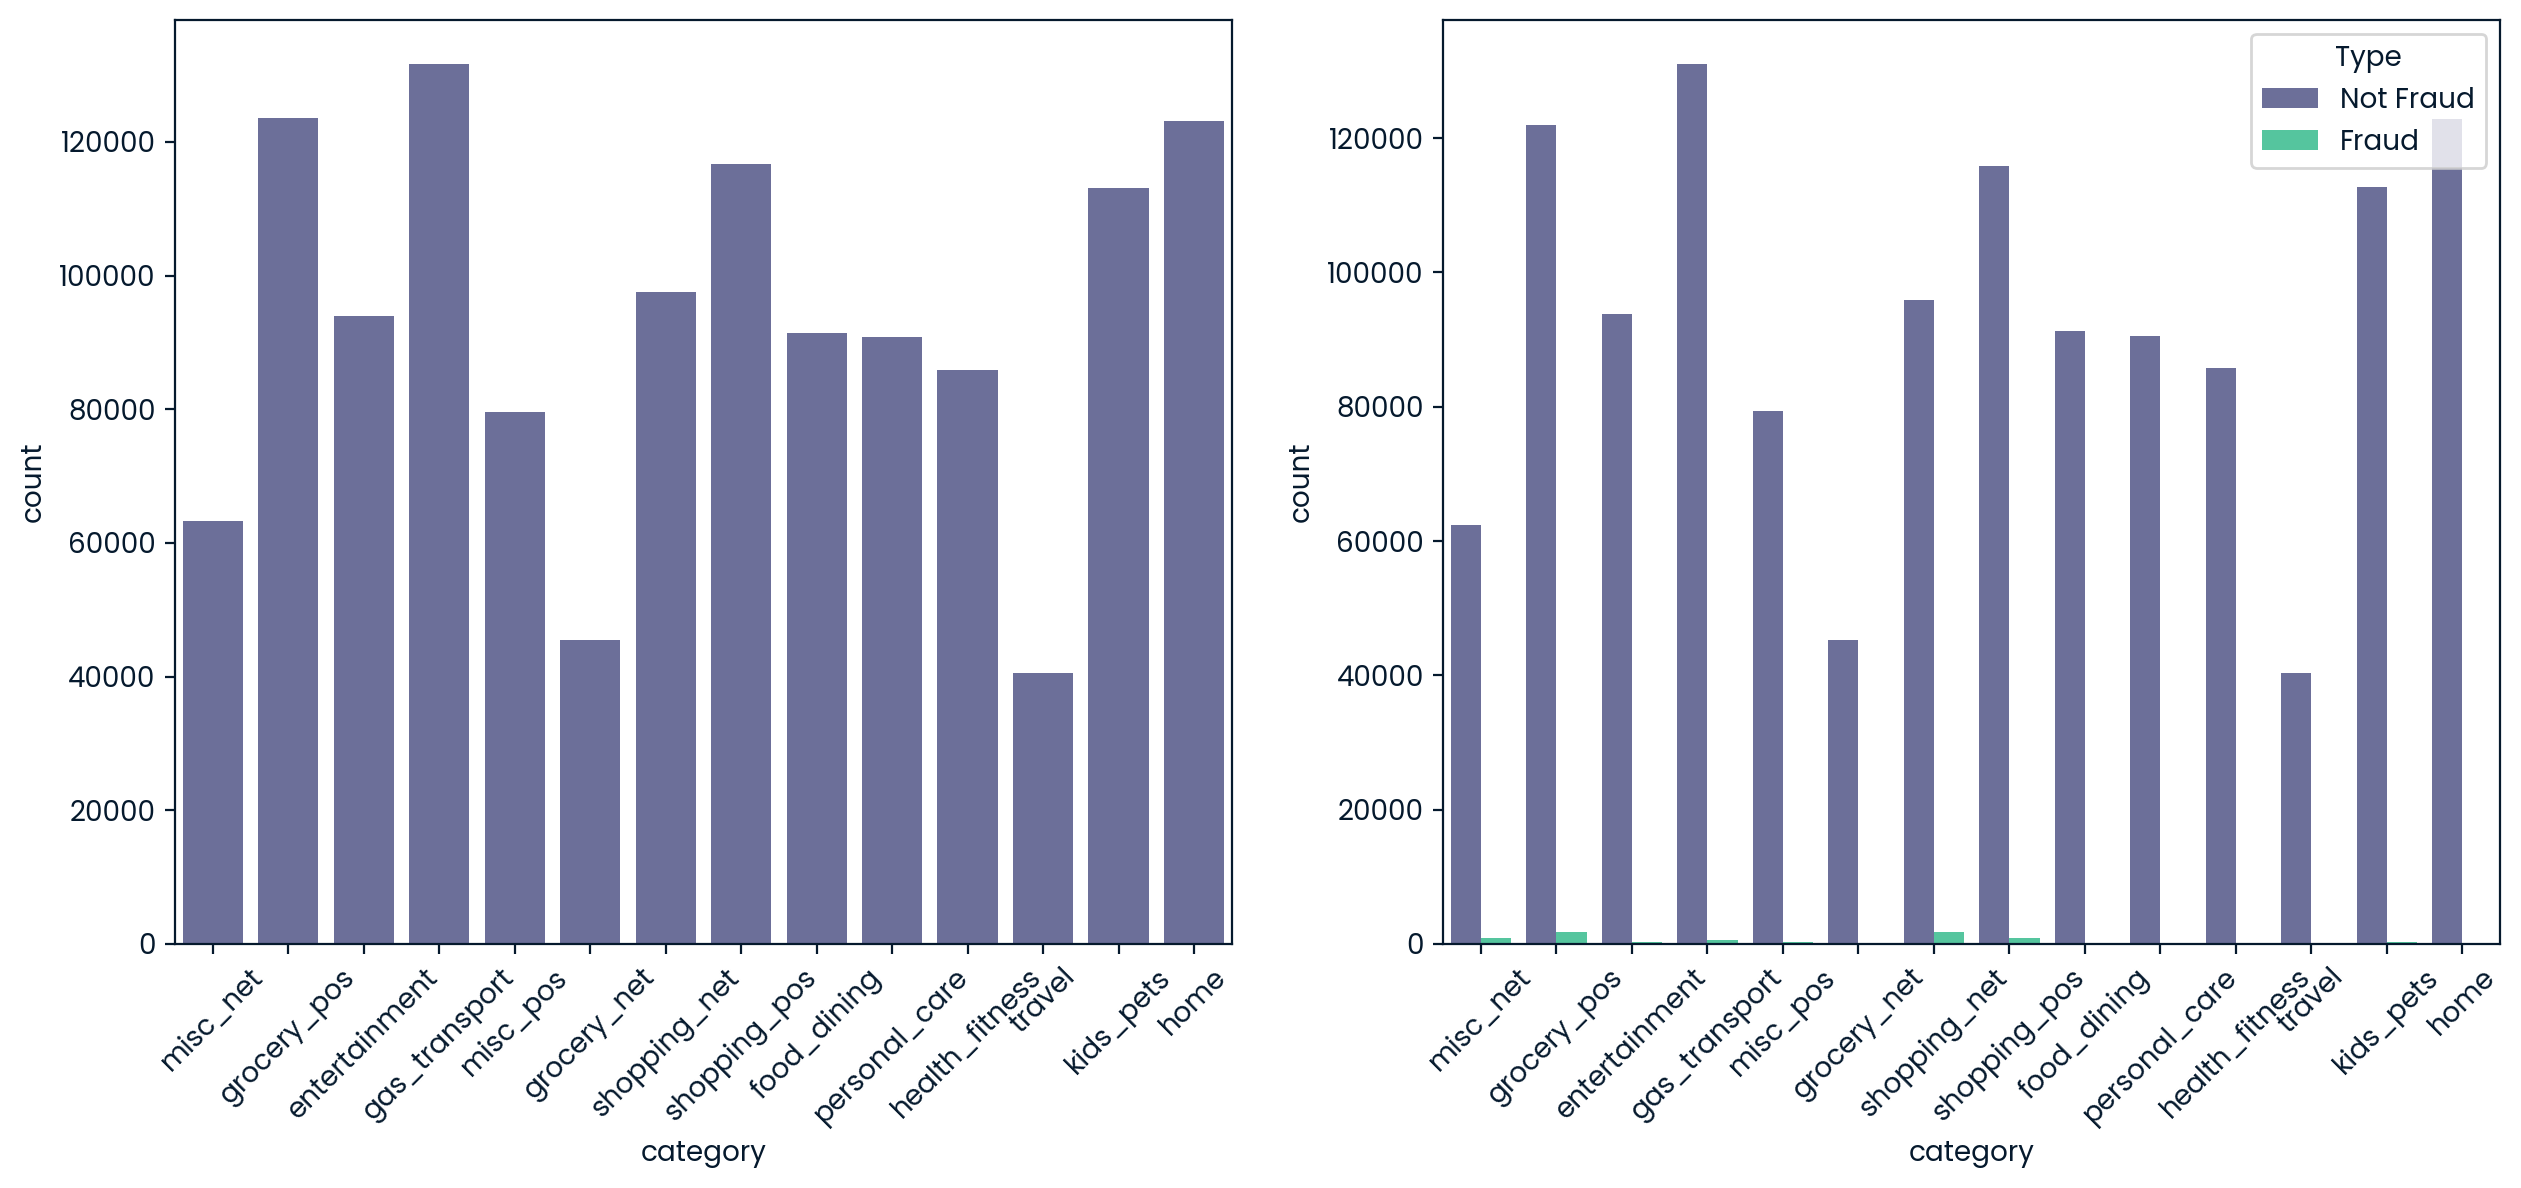

<Figure size 1500x1000 with 0 Axes>

In [46]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.countplot(data=df_subset, x='category', ax=ax1)
sns.countplot(data=df_subset, x='category', hue='is_fraud', ax=ax2)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

plt.legend(title='Type', labels=['Not Fraud', 'Fraud']);
plt.figure(figsize=(15,10))

Similar to the `gender` feature, the class imbalance of the target variable `is_fraud` in the dataset can be seen in the `category` feature distribution in the dataset

<Figure size 1500x1000 with 0 Axes>

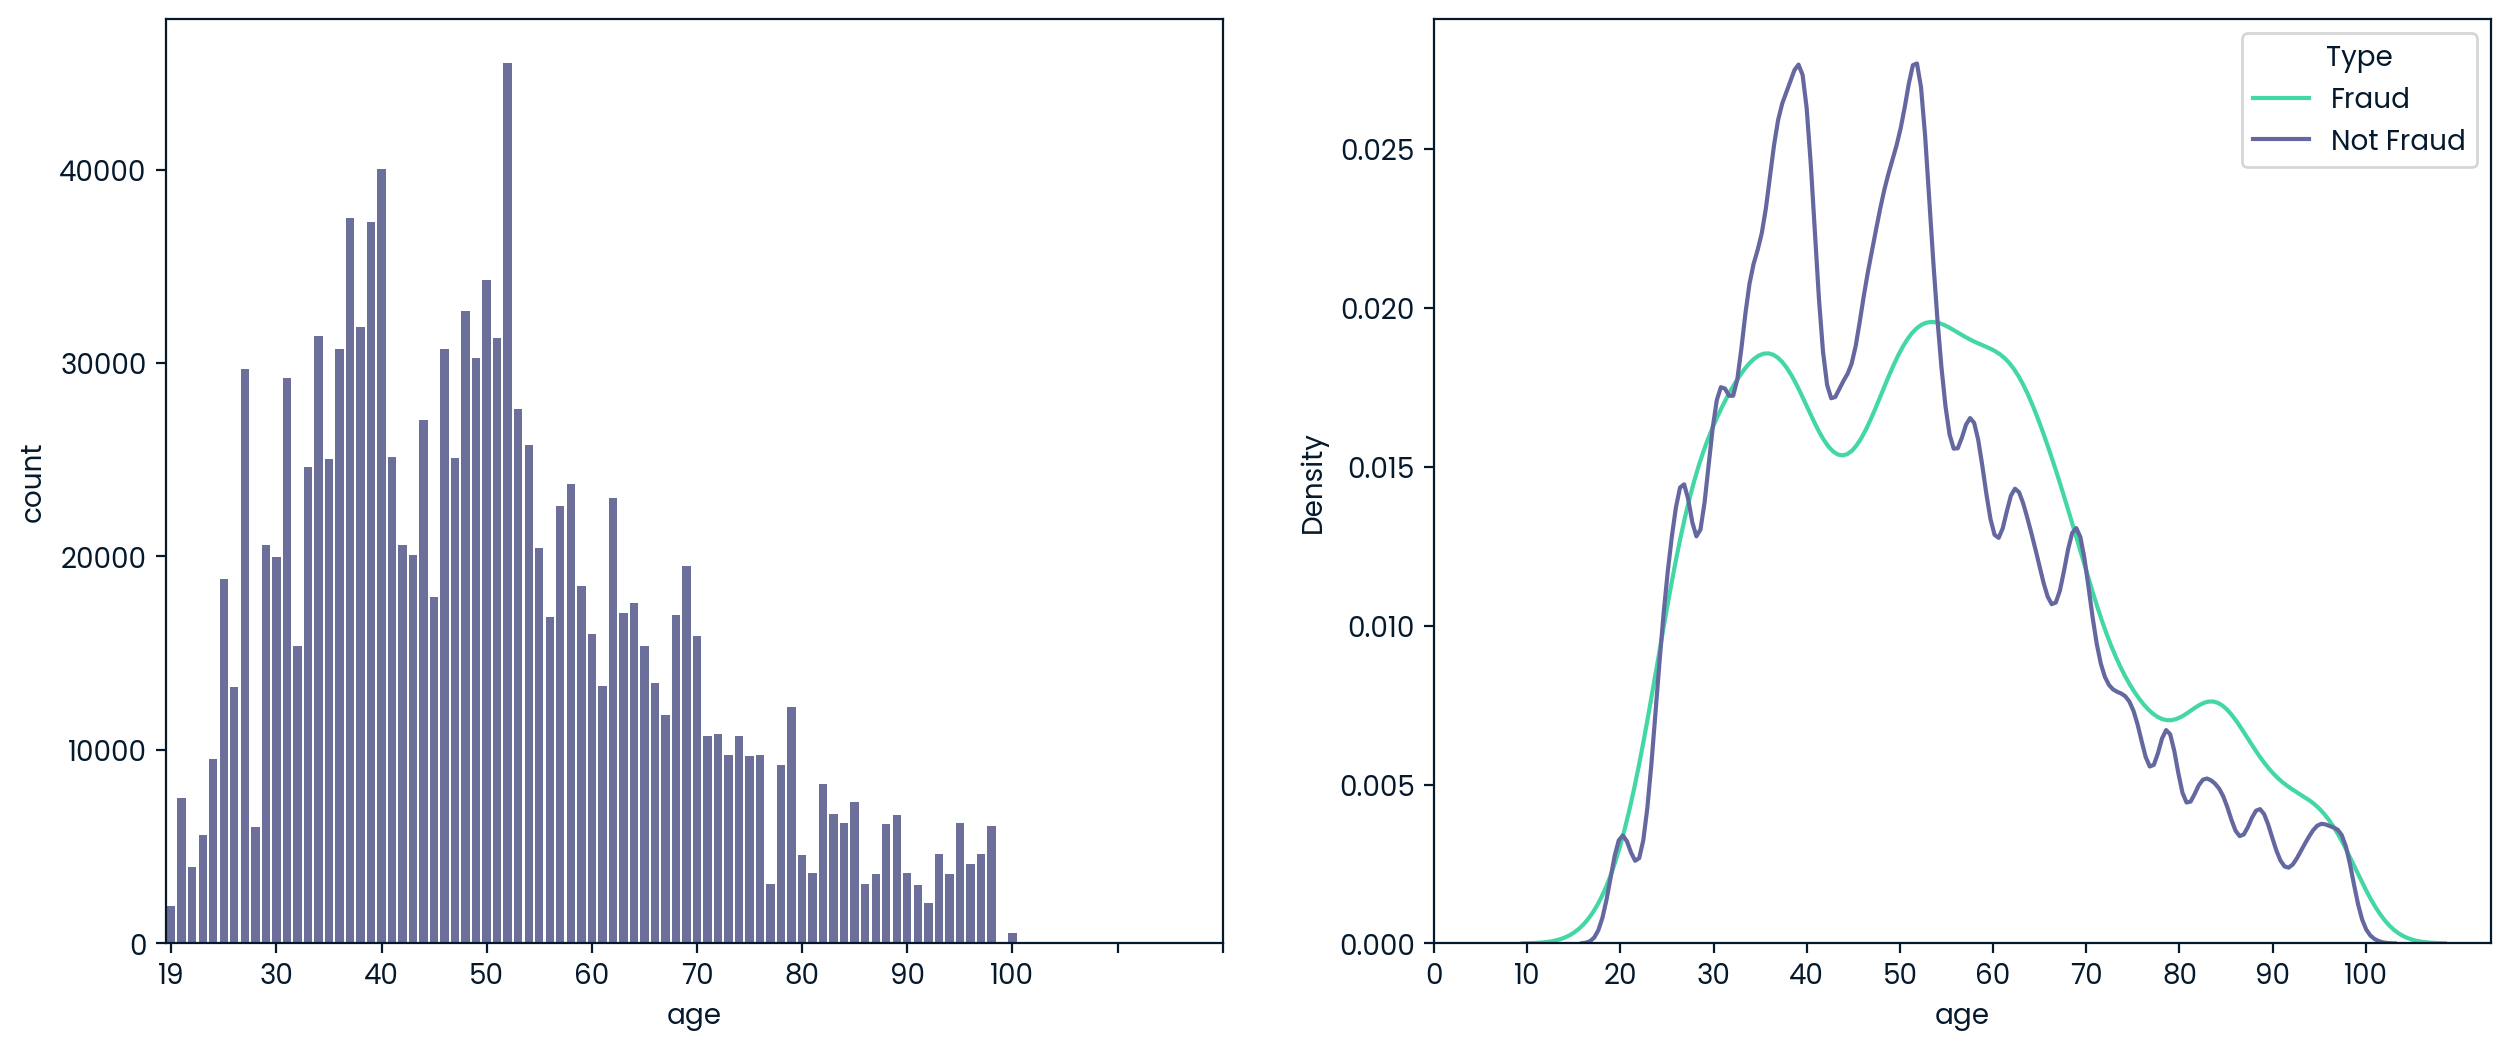

<Figure size 1500x1000 with 0 Axes>

In [47]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
df_subset['age'] = dt.date.today().year-pd.to_datetime(df['dob']).dt.year

sns.countplot(data=df_subset, x='age', ax=ax1)
ax1.set_xticks(np.arange(0, 110, 10))
ax2.set_xticks(np.arange(0, 110, 10))

sns.kdeplot(data=df_subset, x='age', hue='is_fraud', common_norm=False, ax=ax2)
plt.xticks(np.arange(0, 110, 10))
plt.legend(title='Type', labels=['Fraud', 'Not Fraud']);
plt.figure(figsize=(15,10))

It shows that the high rise in transactions by people aged 35 and 55 equally results to increase in the fraudulent and non-fraudulent transactions within the age group  

In [14]:
sns.scatterplot(data=df_subset, x='age', y='city_pop', hue='is_fraud')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud']);

Error in callback <function _draw_all_if_interactive at 0x7f14fde4f4c0> (for post_execute):


This shows that most of the transaction is recorded from less-dense populated areas. Also we can see that the fraudulent transaction is more in an area among the older people.

## Data Preprocessing

In [15]:
# Feature engineering to remove redundant features
df_subset['trans_day'] = pd.to_datetime(df['trans_date_trans_time']).dt.day
df_subset['trans_month'] = pd.to_datetime(df['trans_date_trans_time']).dt.month
df_subset['trans_year'] = pd.to_datetime(df['trans_date_trans_time']).dt.year

df_subset['cc_num_len'] = df['cc_num'].apply(lambda x: len(str(x)))

label_encoder = LabelEncoder()
df_subset['gender'] = label_encoder.fit_transform(df_subset['gender'])
df_subset['category'] = label_encoder.fit_transform(df_subset['category'])

df_subset.drop(['trans_date_trans_time', 'dob', 'cc_num', 'city', 'state'], inplace=True, axis=1)
df_subset.head()

,category,amt,gender,zip,city_pop,is_fraud,age,trans_day,trans_month,trans_year,cc_num_len
0,8,4.97,0,28654,3495,0,36,1,1,2019,16
1,4,107.23,0,99160,149,0,46,1,1,2019,12
2,0,220.11,1,83252,4154,0,62,1,1,2019,14
3,2,45.00,1,59632,1939,0,57,1,1,2019,16
4,9,41.96,1,24433,99,0,38,1,1,2019,15


Here, I performed some feature engineering to reduce the features in the datset by removing redundant features

In [16]:
df_subset.shape

(1296675, 11)

I have dropped redundant features and reduced the number of features from 22 to 11

In [17]:
# Perform preprocessing
df_subset.dtypes

category         int64
amt            float64
gender           int64
zip              int64
city_pop         int64
is_fraud         int64
age              int64
trans_day        int64
trans_month      int64
trans_year       int64
cc_num_len       int64
dtype: object

I have succesfully engineered all the features in the dataset to numeric values by feature selection and extraction

## Predict if a transaction is fraudulent or not

In [18]:
X = df_subset.drop(['is_fraud'], axis=1)
y = df_subset['is_fraud']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [19]:
# Train model with undersampling
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
print(y_train_resampled.value_counts())
print(y_test.value_counts())

0    5254
1    5254
Name: is_fraud, dtype: int64
0    386751
1      2252
Name: is_fraud, dtype: int64


The imbalance in the target variable `is_fraud` can result in poor generalization performance, therefore, I had too undersample the dataset i.e reducing the instances of the large class in the training sample to match the size of the lower class

In [20]:
# Instantiate a MinMaxScaler
scaler = MinMaxScaler()

#### Setting up the pipelines
Pipelines will be set up for each model we will try: Random Forest and Decision Tree are good models for binary classification, Logistic Regression is included for benchmarking too

In [21]:
#set up pipelines with preprocessing & estimators
pipelines = {
    'lr': make_pipeline(scaler, LogisticRegression(random_state=42)),
    'rf': make_pipeline(scaler, RandomForestClassifier(random_state=42)),
    'dt': make_pipeline(scaler, DecisionTreeClassifier(random_state=42)),
}

#### Evaluating the simple models
The *roc-curve* shows how well the model performs: The more area under the curve, the better the model. We can plot the curve for each of the three models in the pipeline, and show its *accuracy* (ACC) and *Area-Under-the-Curve* (AUC). The visual shows that ***rf* is the best of the naive models**, with the highest AUC and ACC.

In [22]:
def evaluate_model(features, target, model, model_name='Model', title=None, normalize_matrix=None):
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    if title is not None:
        f.suptitle(title, fontsize=16)
    
    preds = model.predict(features)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(features)[:, 1]
    else:
        y_score = None
    
    accuracy = accuracy_score(target, preds)
    precision = precision_score(target, preds)
    recall = recall_score(target, preds)
    f1 = f1_score(target, preds)
    auc = roc_auc_score(target, y_score) if y_score is not None else None

    c_matrix = confusion_matrix(target, preds, normalize=normalize_matrix)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=model.classes_)
    
    cm_display.plot(ax=ax1)
    ax1.grid(False)
    ax1.set_title("{} Confusion matrix".format(model_name))

    if y_score is not None:
        fpr, tpr, threshold = roc_curve(target, y_score)
        ax2.plot(fpr, tpr, label=model_name)
        ax2.plot([0, 1], [0, 1], linestyle="--", c="grey", label='Random Guess')
        ax2.set_title("{} ROC Curve".format(model_name))
        plt.legend()

    plt.figure(figsize=(15,10))
    plt.show()

    print("Accuracy", accuracy.round(2))
    print("Precision:", precision.round(2))
    print("Recall:", recall.round(2))
    print("F1 Score", f1.round(2))
    if auc is not None:
        print("AUC:", auc)
        
    return None

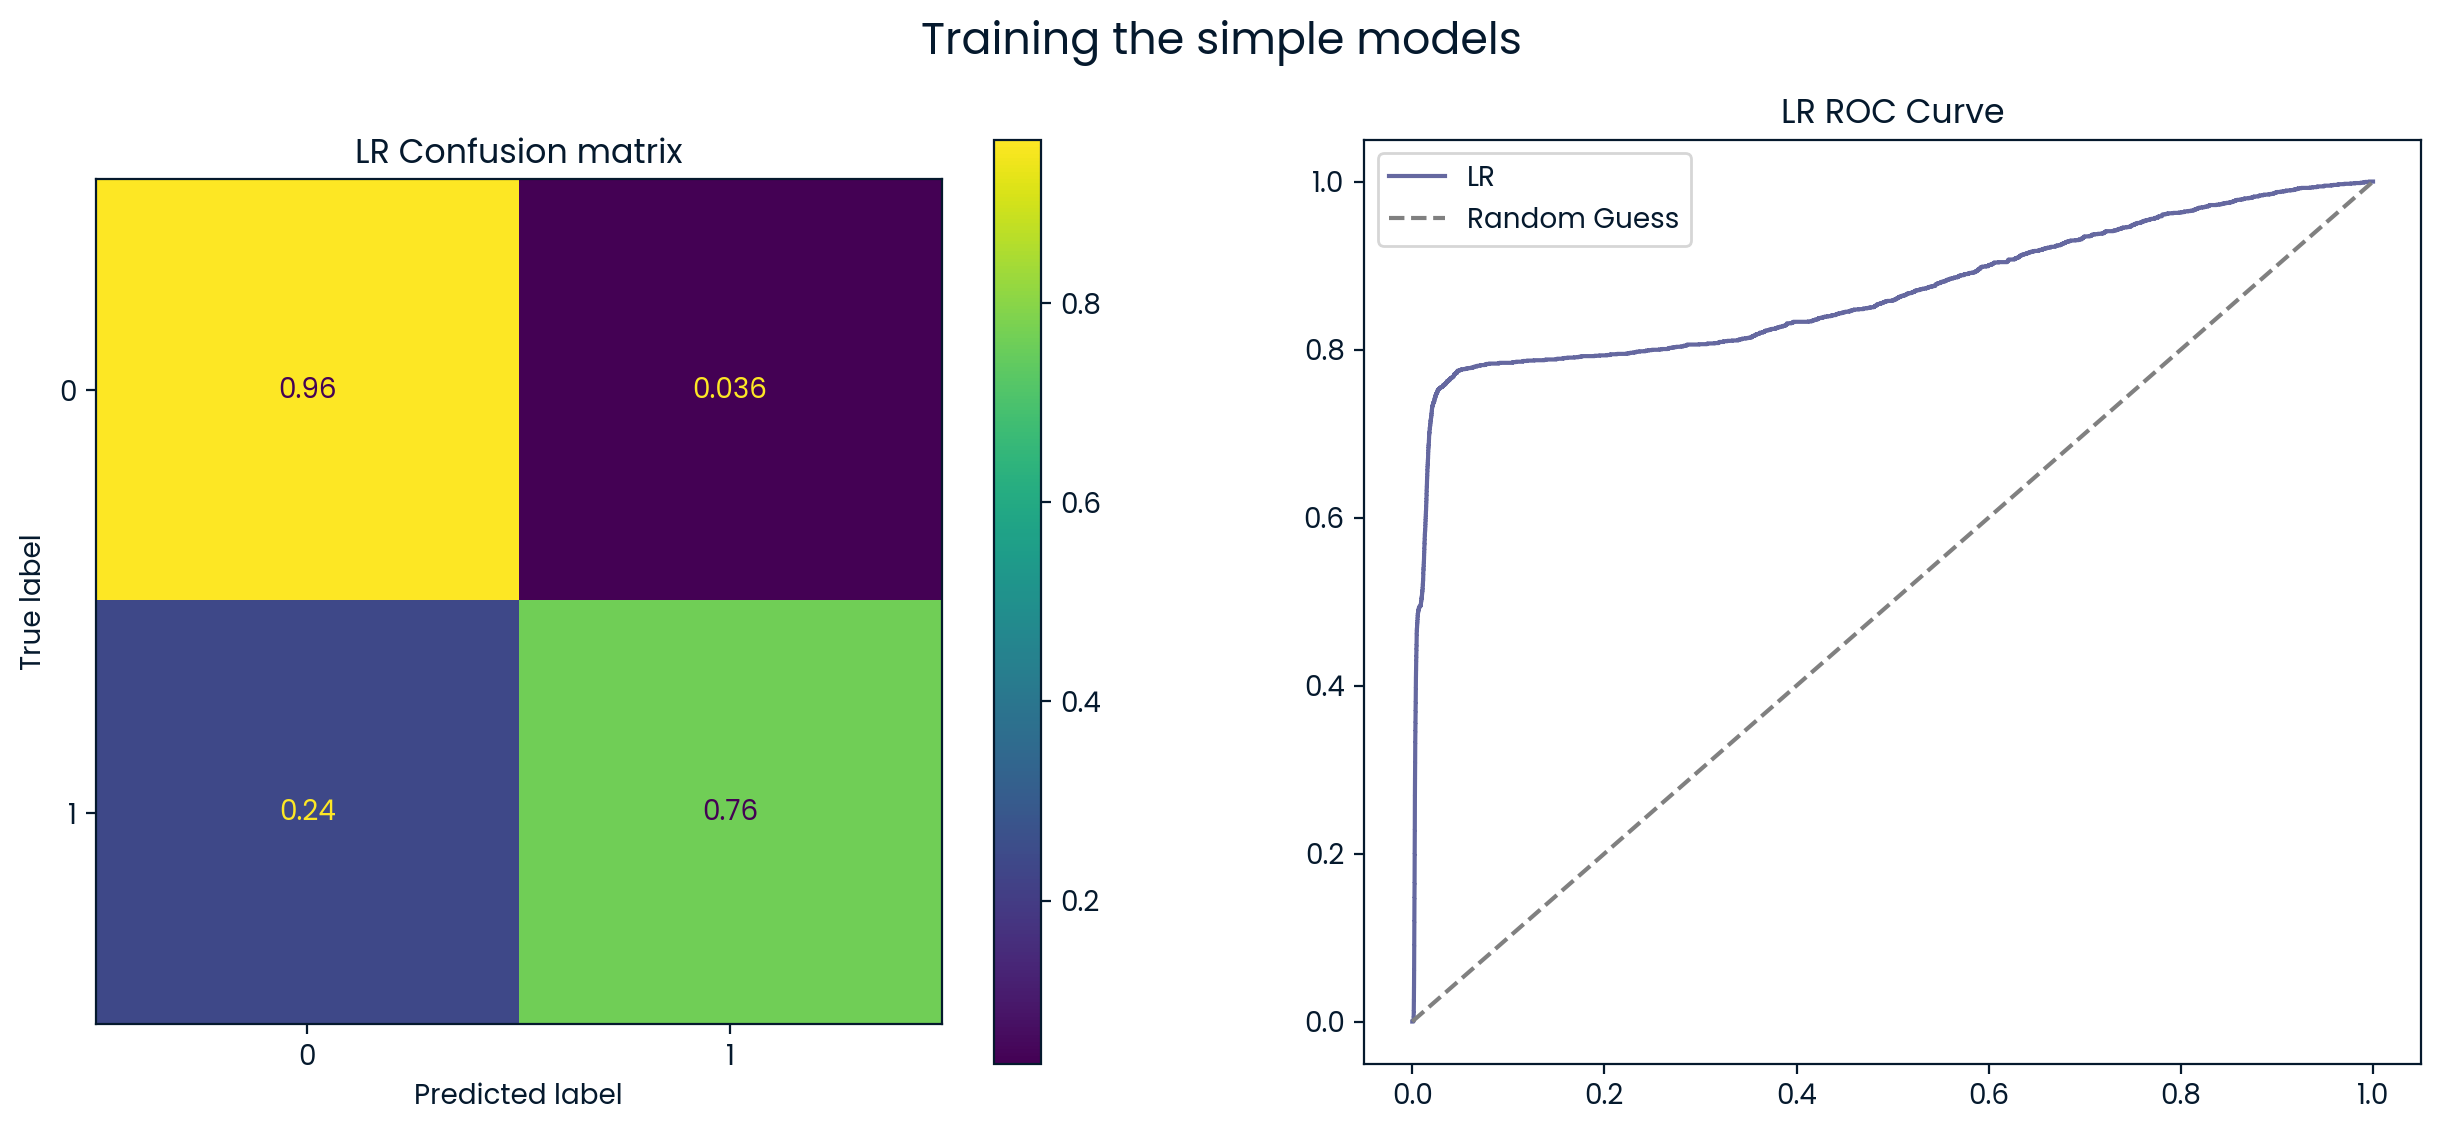

<Figure size 1500x1000 with 0 Axes>

Accuracy 0.96
Precision: 0.11
Recall: 0.76
F1 Score 0.19
AUC: 0.8680432409334303


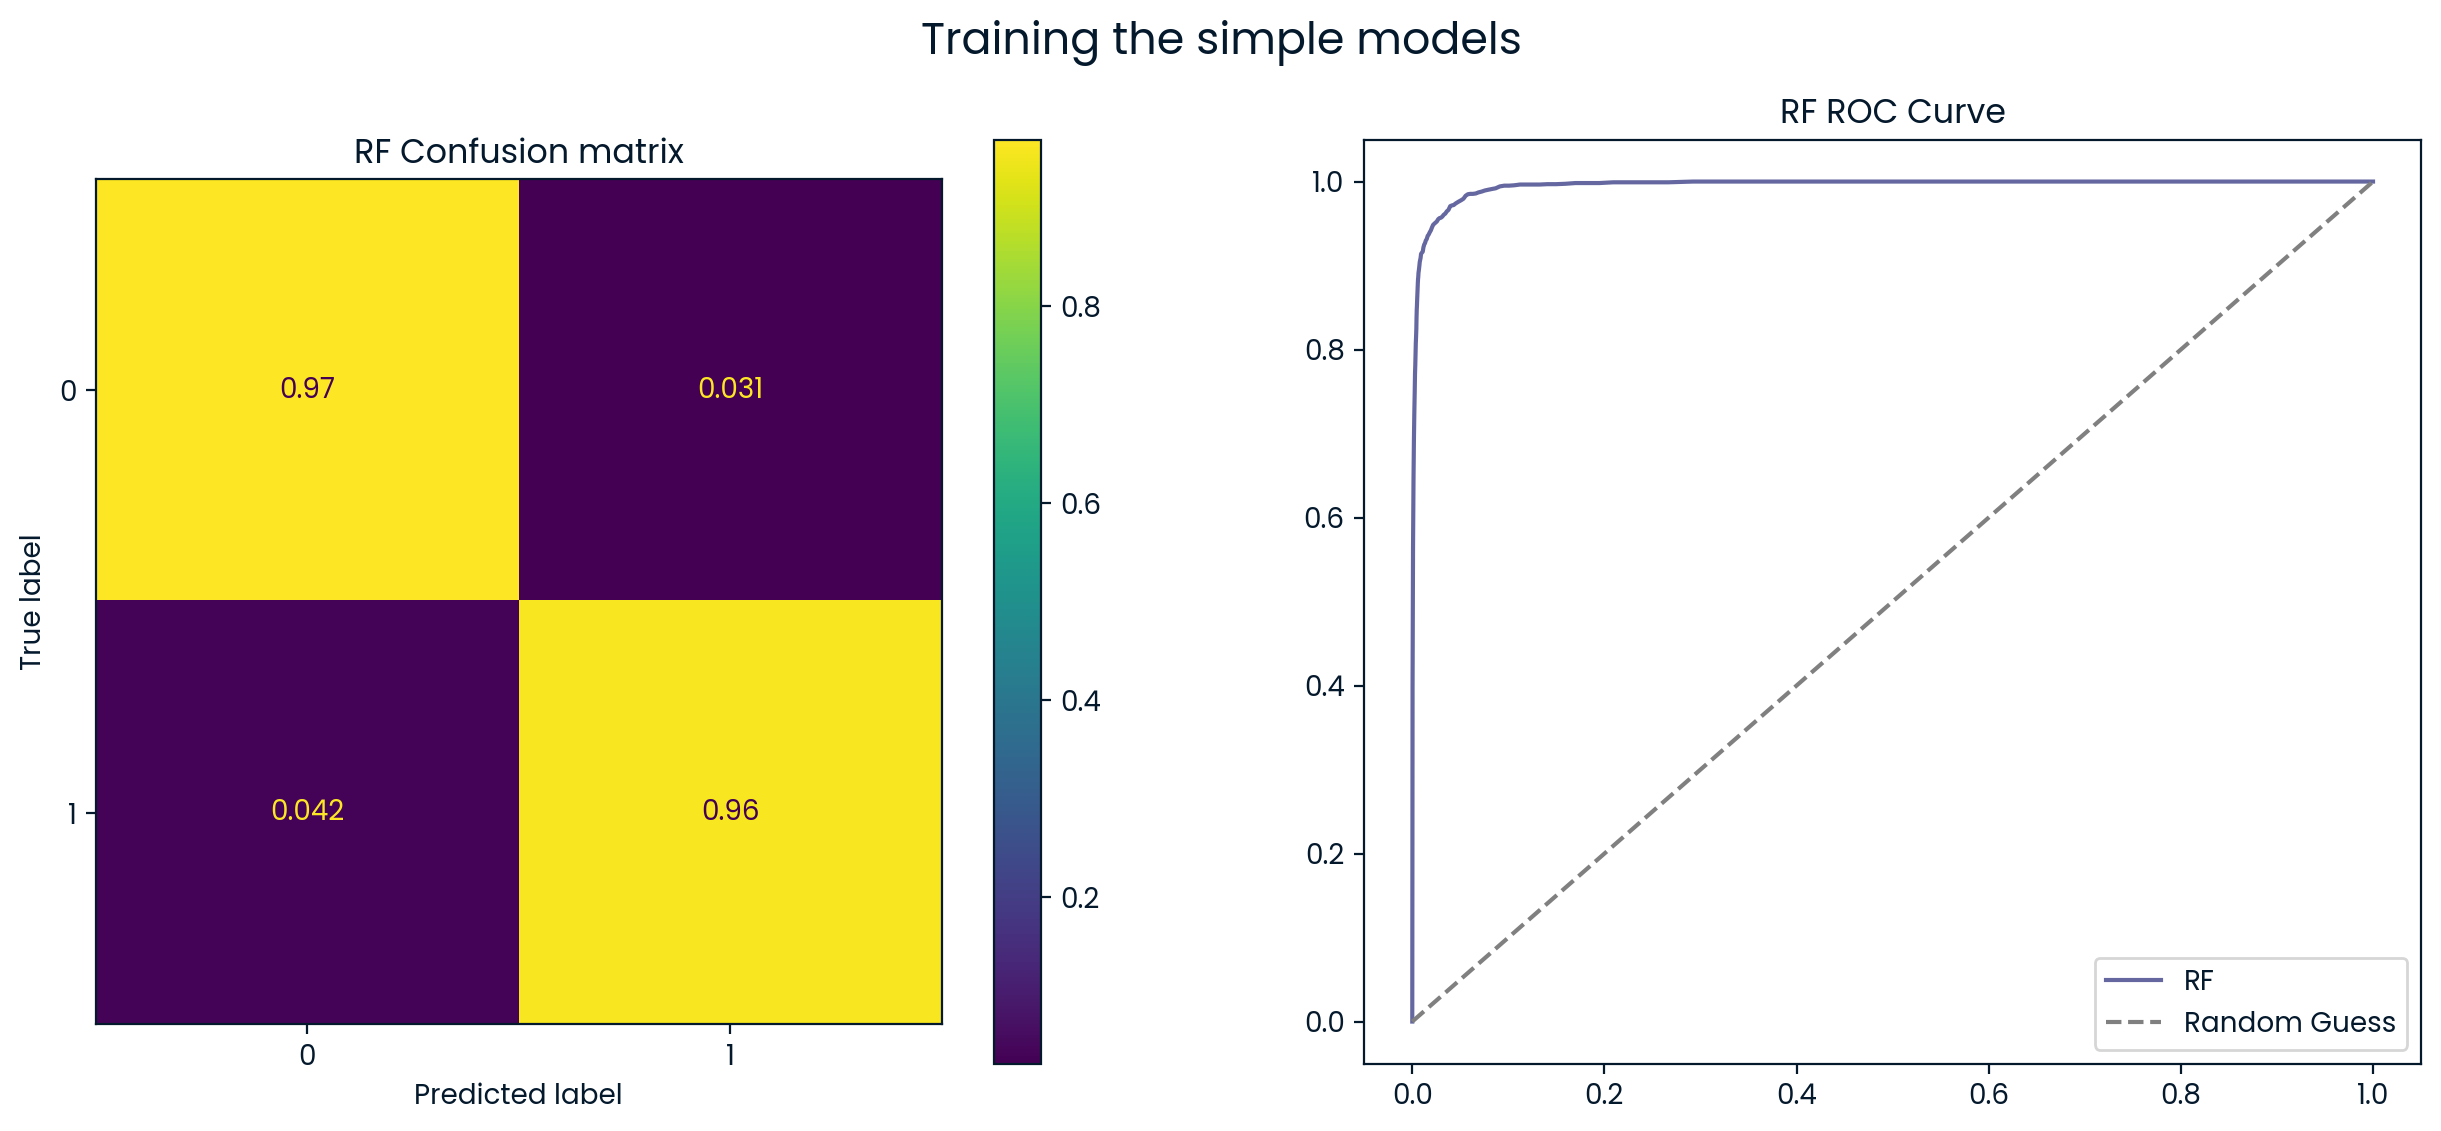

<Figure size 1500x1000 with 0 Axes>

Accuracy 0.97
Precision: 0.15
Recall: 0.96
F1 Score 0.26
AUC: 0.9952293394807891


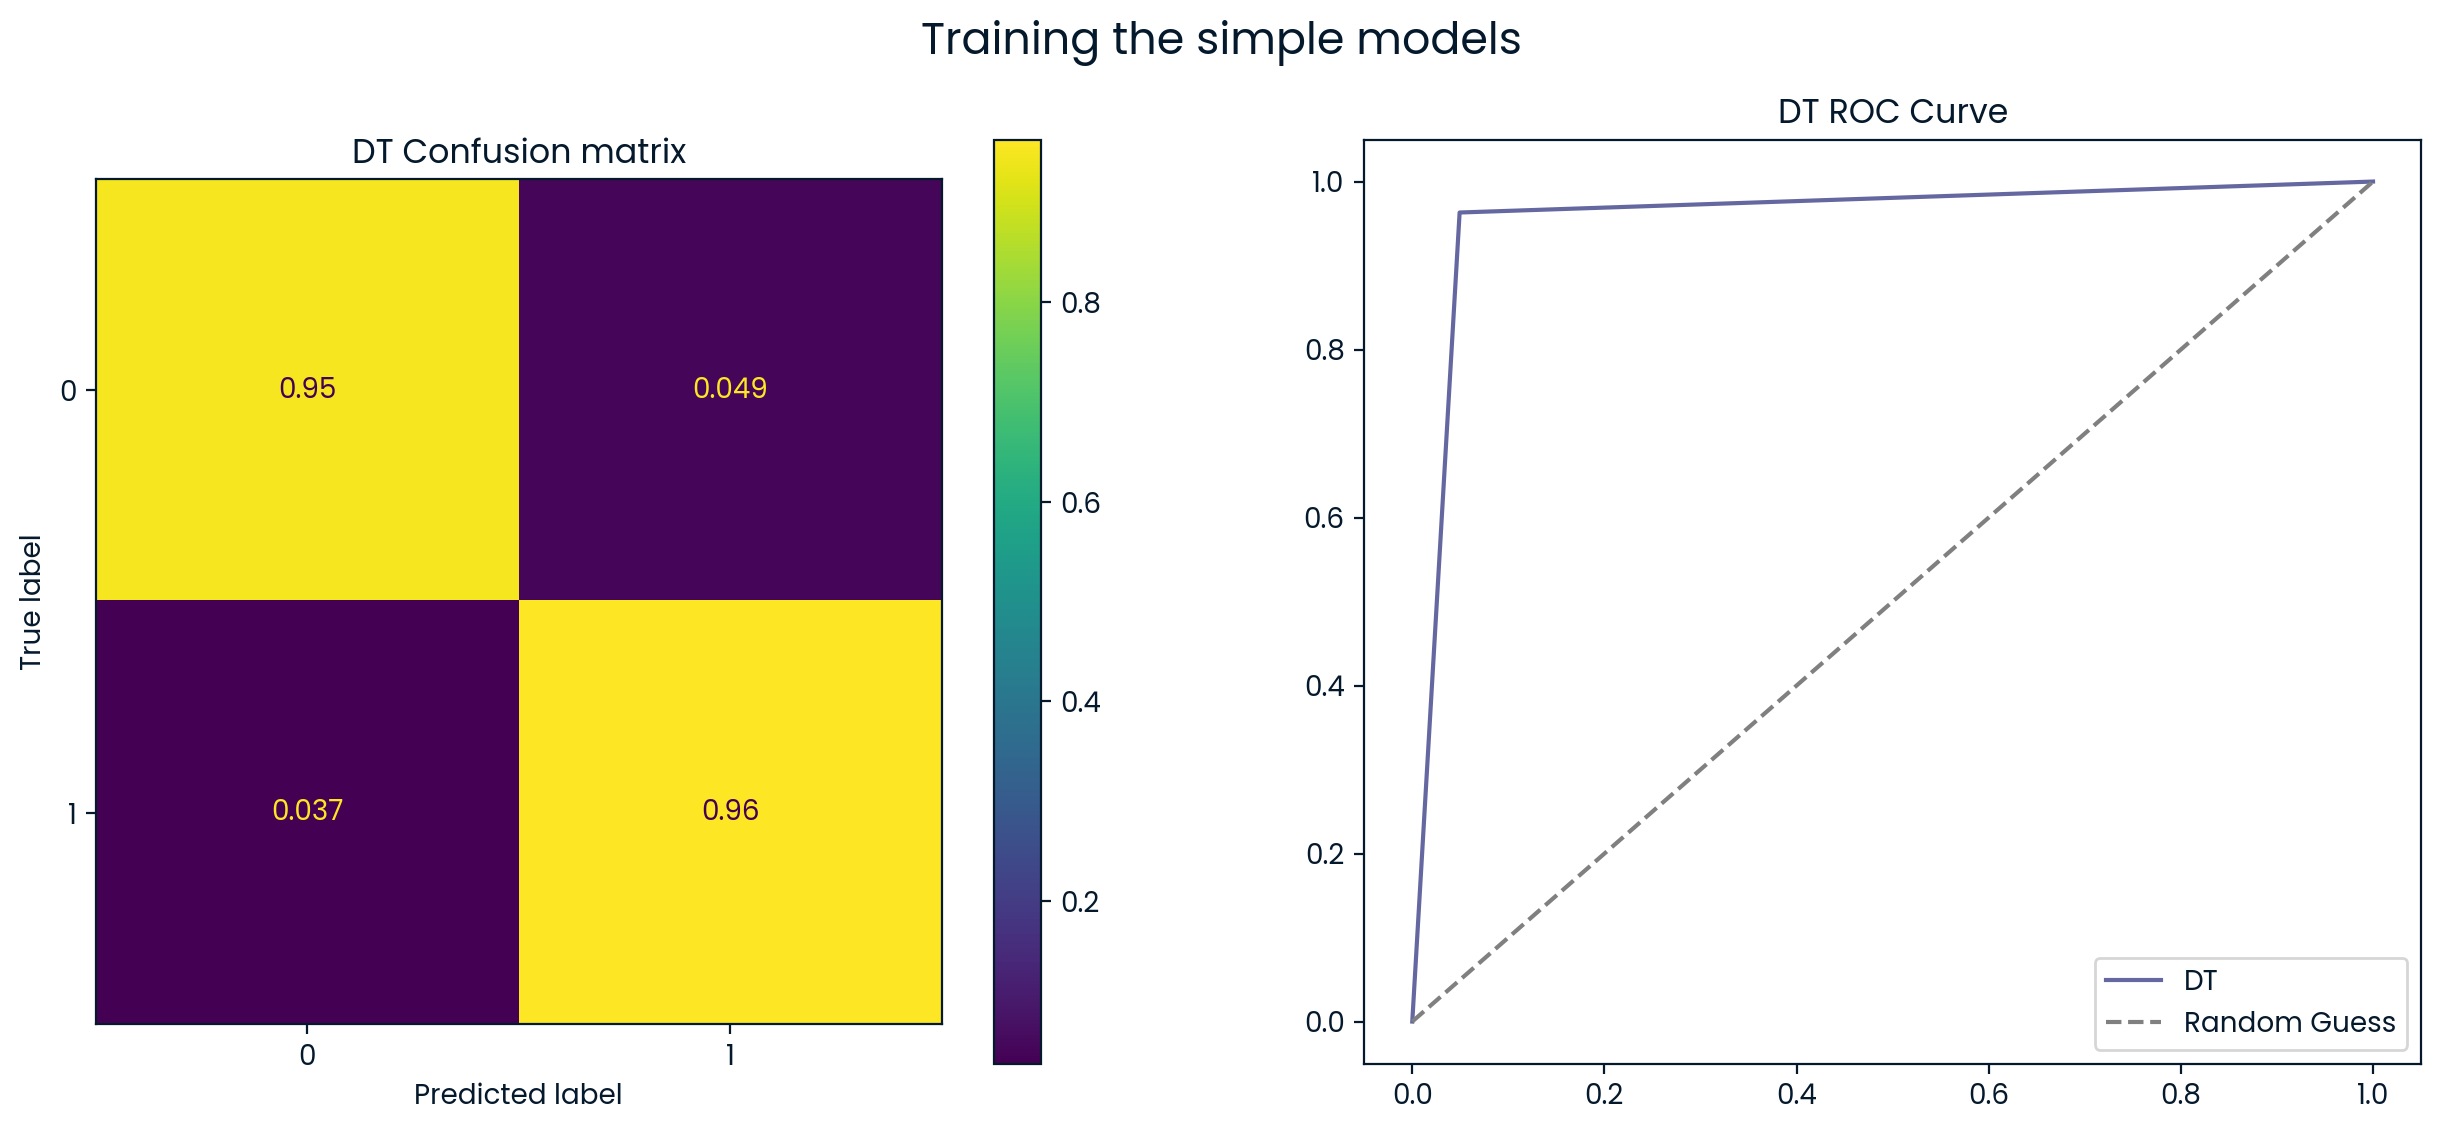

<Figure size 1500x1000 with 0 Axes>

Accuracy 0.95
Precision: 0.1
Recall: 0.96
F1 Score 0.18
AUC: 0.9569320514799401


In [23]:
for name, estimator in pipelines.items():
    estimator.fit(X_train_resampled, y_train_resampled)
    evaluate_model(X_test, y_test, estimator, name.upper(), 'Training the simple models', normalize_matrix='true')


Random Forest and Decision Tree models is performing well the training data which seems to be as a result of overfitting and fine-tuning the model's hyperparameters may be beneficial to address overfitting.

#### Hyperparameter fine-tuning
Now that we have an idea of the bare minimum of model performance we can perform a Grid Search to fine-tune the hyperparameters of each model. Due to the class imbalance, the score we want to maximize is *auc*.

In [24]:
#dictionary for hyperparameters (hyperparameter grid) to tune per algorithm:

lr_hyperparameters = {
    'logisticregression__C': [0.001, 0.005, 0.01, 0.05, 0.1, 1, 10, 100],
    'logisticregression__penalty':['l1','l2'],
    'logisticregression__tol':[0.0001, 0.0003, 0.001],
    'logisticregression__max_iter':[100,200,300,400,500],
    'logisticregression__solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'],
    'logisticregression__class_weight': ['balanced']
}

rf_hyperparameters = {
    'randomforestclassifier__max_depth' : np.arange(1,4,1),
    'randomforestclassifier__max_leaf_nodes' : np.arange(13,17,1),
    'randomforestclassifier__min_samples_leaf': np.arange(2,5),
    'randomforestclassifier__n_estimators' : [100, 200,300,],
    'randomforestclassifier__min_samples_split' : [4,5,6],    
}

dt_hyperparameters = {
    'decisiontreeclassifier__max_leaf_nodes': list(range(0, 10)), 
    'decisiontreeclassifier__min_samples_split': [0,1,2,3, 4], 
    'decisiontreeclassifier__min_samples_leaf': [0,1,2, 3, 4], 
    'decisiontreeclassifier__max_depth':[0,1,2,3,4,5],
    'decisiontreeclassifier__max_features':[0,1,2,3,4,5],
    'decisiontreeclassifier__max_leaf_nodes':[0,1,2,3,4,5]
}

param_grid = {
    'lr': lr_hyperparameters,
    'rf': rf_hyperparameters,
    'dt': dt_hyperparameters,
}


**Training the fine-tuned models**

In [25]:
fitted_models = {}
for name, estimator in pipelines.items():
    print("fitting model:",name,"...")
    model = GridSearchCV(estimator, 
                         param_grid=param_grid[name], 
                         cv=3, 
                         scoring='accuracy',
                         verbose=1, 
                         n_jobs=-1,
                        )
    model.fit(X_train_resampled, y_train_resampled)
    fitted_models[name] = model
    print('---')
          

fitting model: lr ...
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
---
fitting model: rf ...
Fitting 3 folds for each of 324 candidates, totalling 972 fits
---
fitting model: dt ...
Fitting 3 folds for each of 5400 candidates, totalling 16200 fits
---


**Evaluating the fine-tuned models**

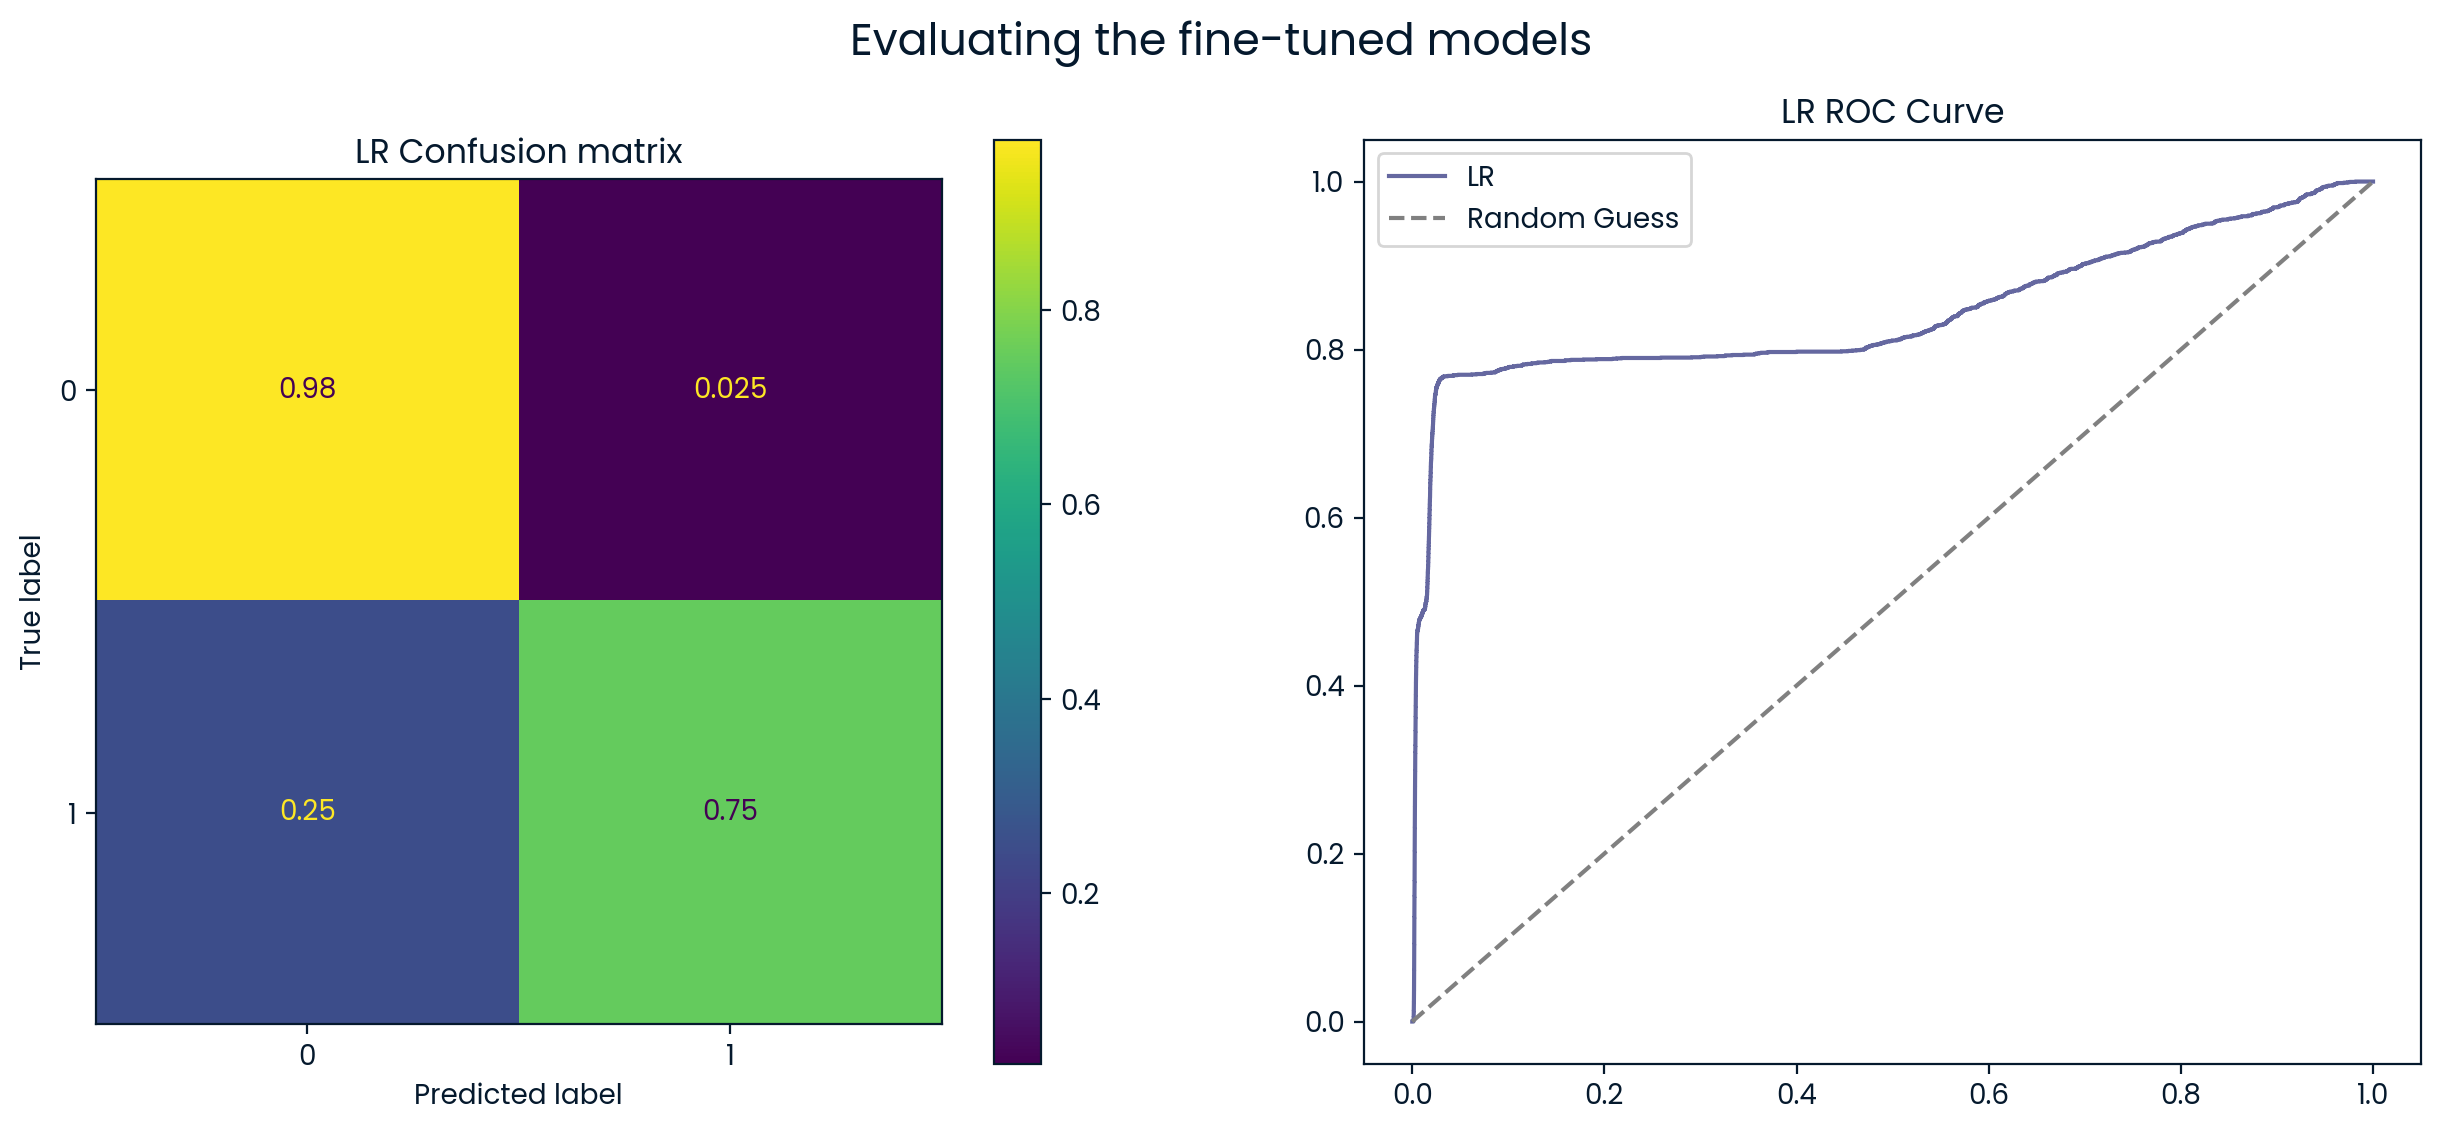

<Figure size 1500x1000 with 0 Axes>

Accuracy 0.97
Precision: 0.15
Recall: 0.75
F1 Score 0.25
AUC: 0.8447893987609938


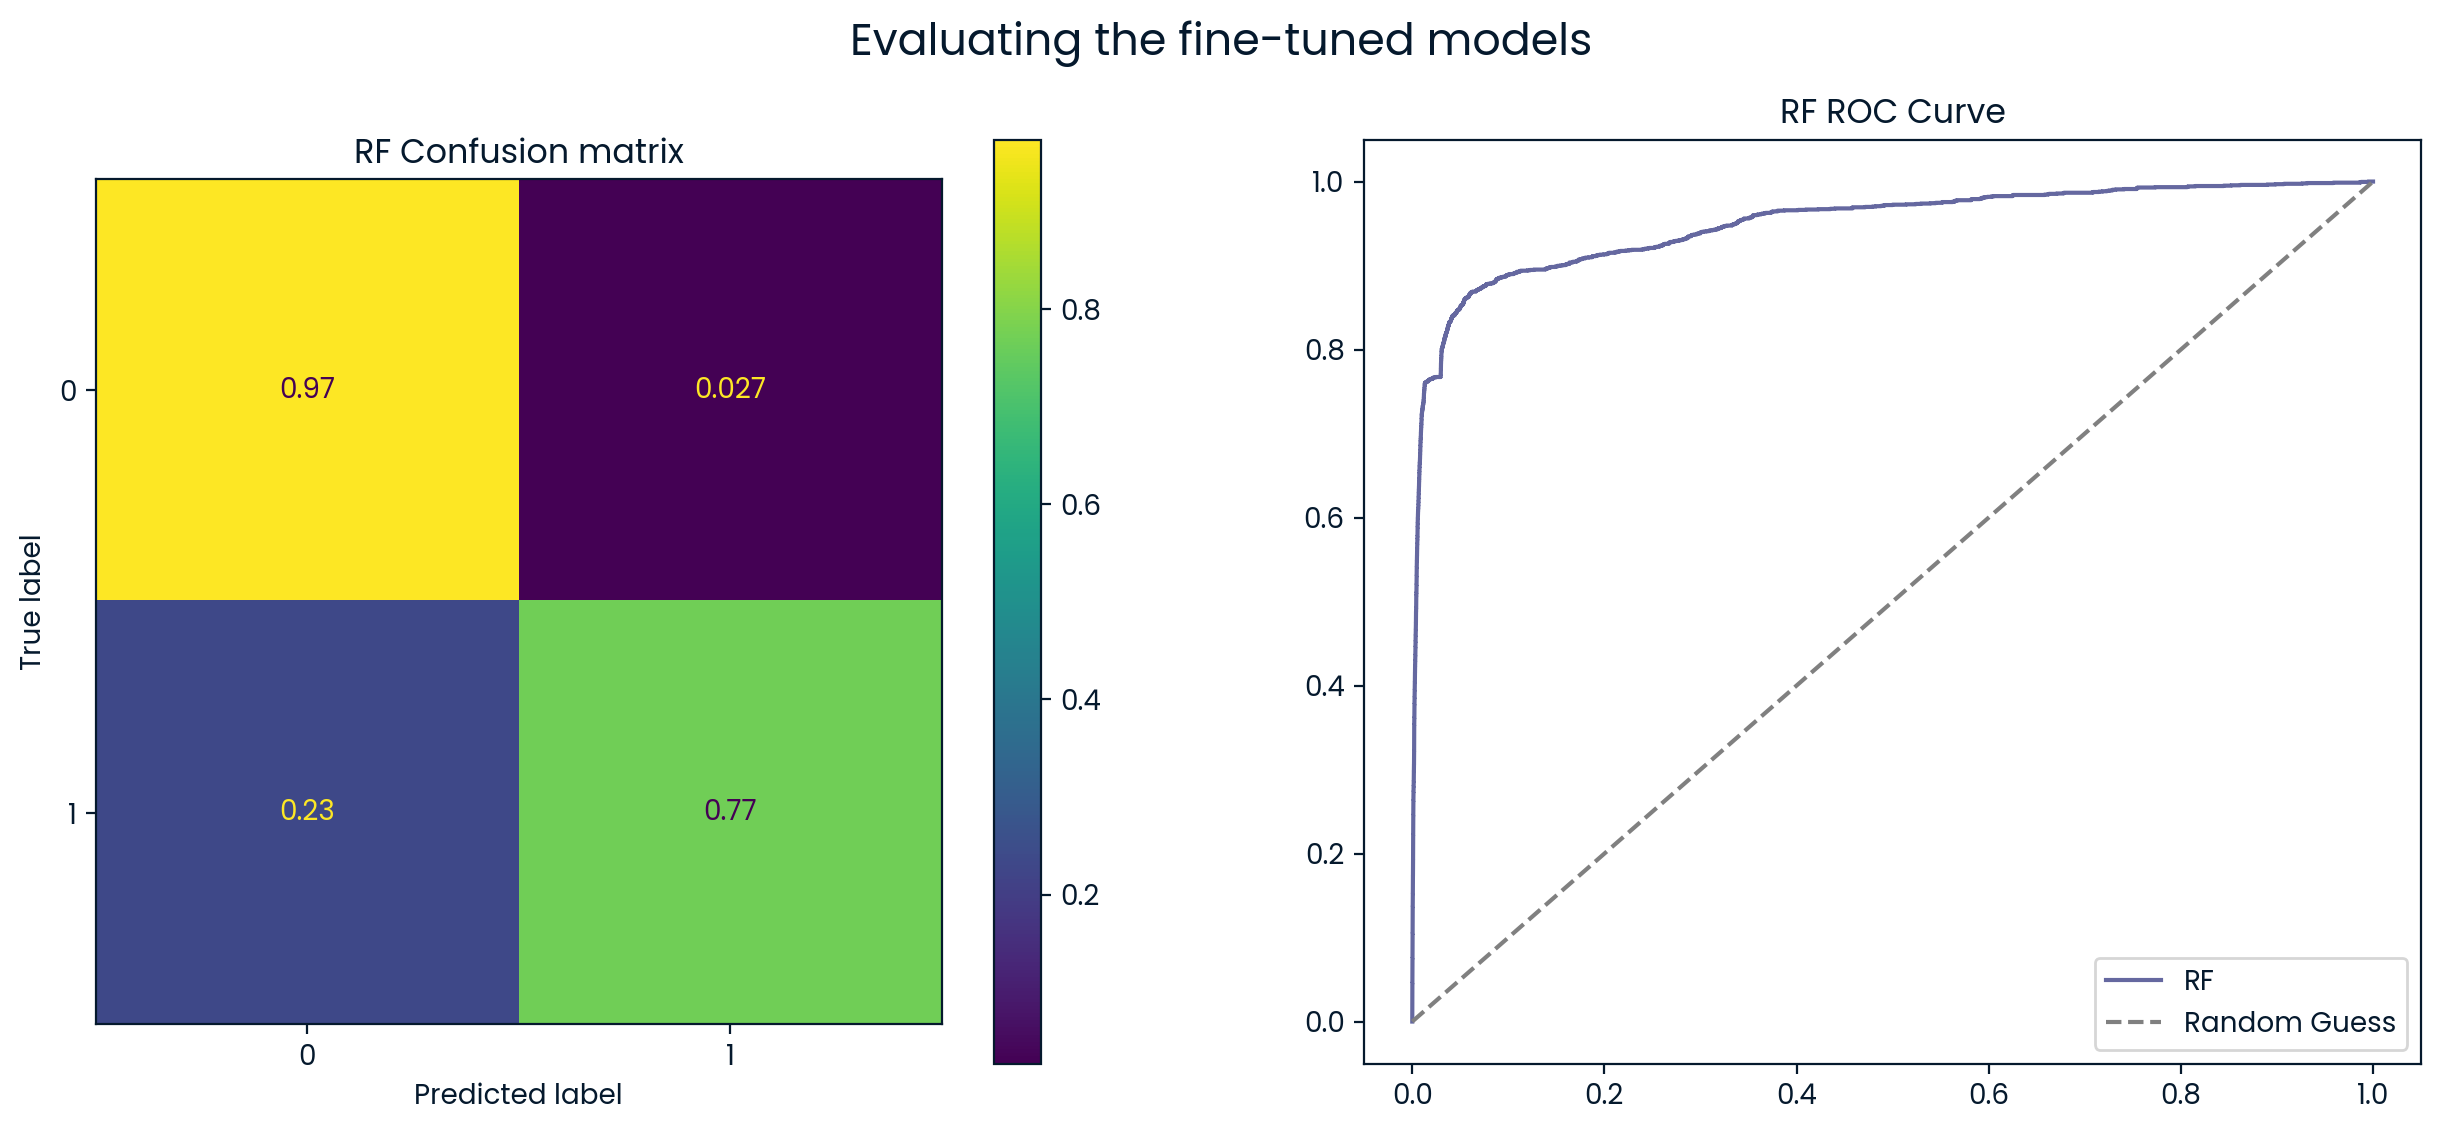

<Figure size 1500x1000 with 0 Axes>

Accuracy 0.97
Precision: 0.14
Recall: 0.77
F1 Score 0.24
AUC: 0.9498162191118484


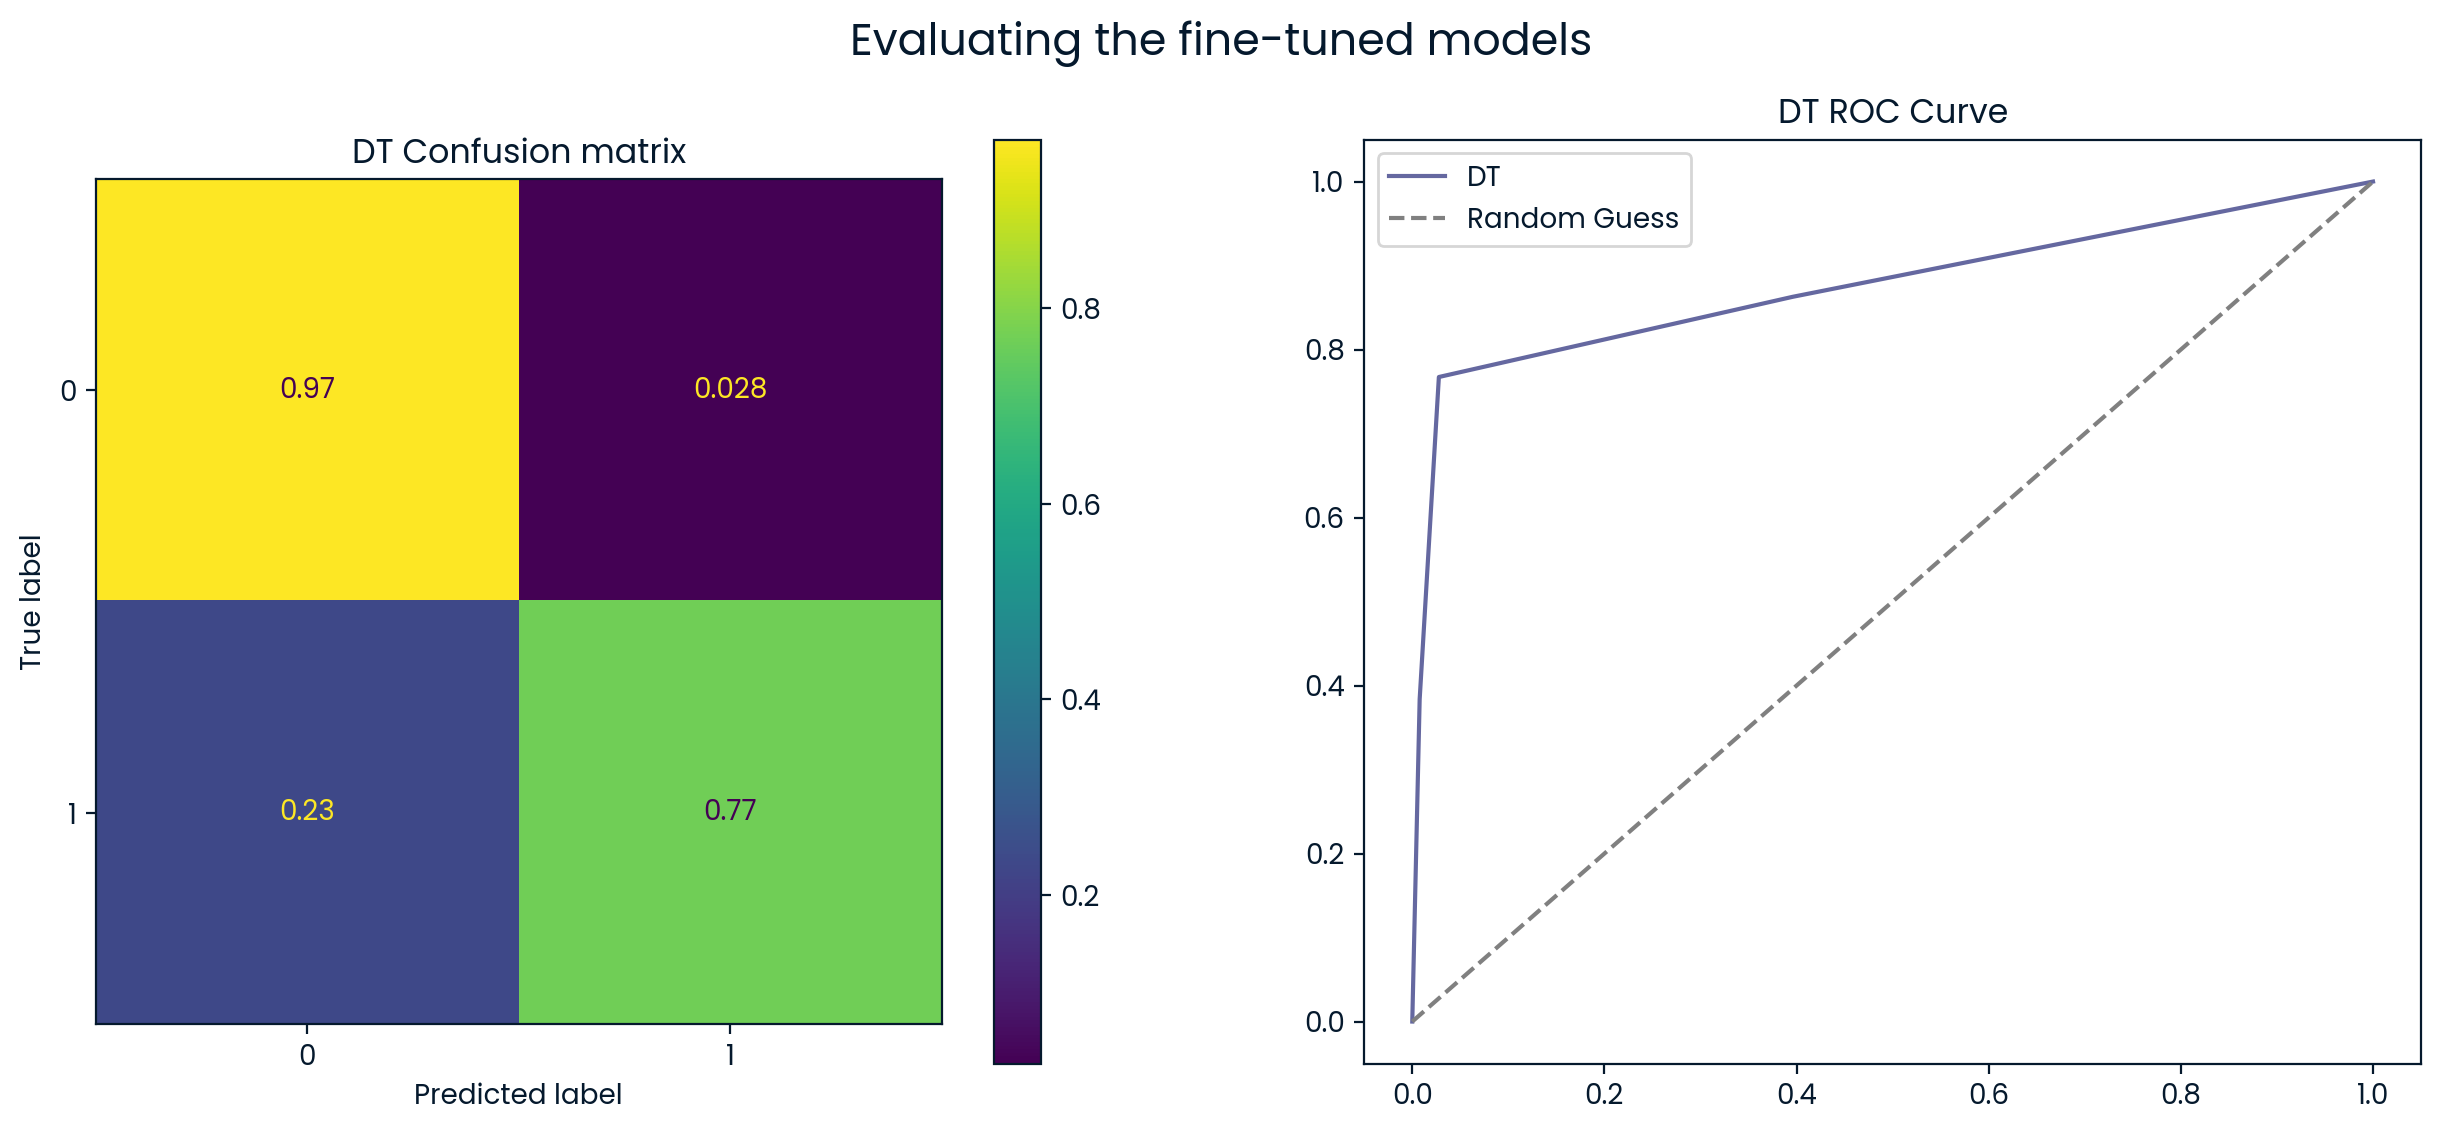

<Figure size 1500x1000 with 0 Axes>

Accuracy 0.97
Precision: 0.14
Recall: 0.77
F1 Score 0.24
AUC: 0.8757472180927329


In [26]:
for name, model in fitted_models.items():
    evaluate_model(X_test, y_test, model, name.upper(), 'Evaluating the fine-tuned models', normalize_matrix='true')


The visual suggests that ***RF* is marginally better with 0.07 higher AUC** than the second one, *Decision Tree.* However, the accuracies are similar

#### Applying AdaBoost on Random Forest
Now, let's try to booost the performing model by applying AdaBoost to the best hyper-parameters of a Random Forest, maximizing the roc_auc score, and plot the roc curve of the best combination:

#### Best Hyperparams

In [27]:
# Get the best parameters of the classifier
best_param = fitted_models['rf'].best_estimator_
print(best_param)


(Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=3, max_leaf_nodes=13,
                                        min_samples_leaf=2, min_samples_split=6,
                                        n_estimators=300, random_state=42))]),)


#### The final model for predicting a successful shot:


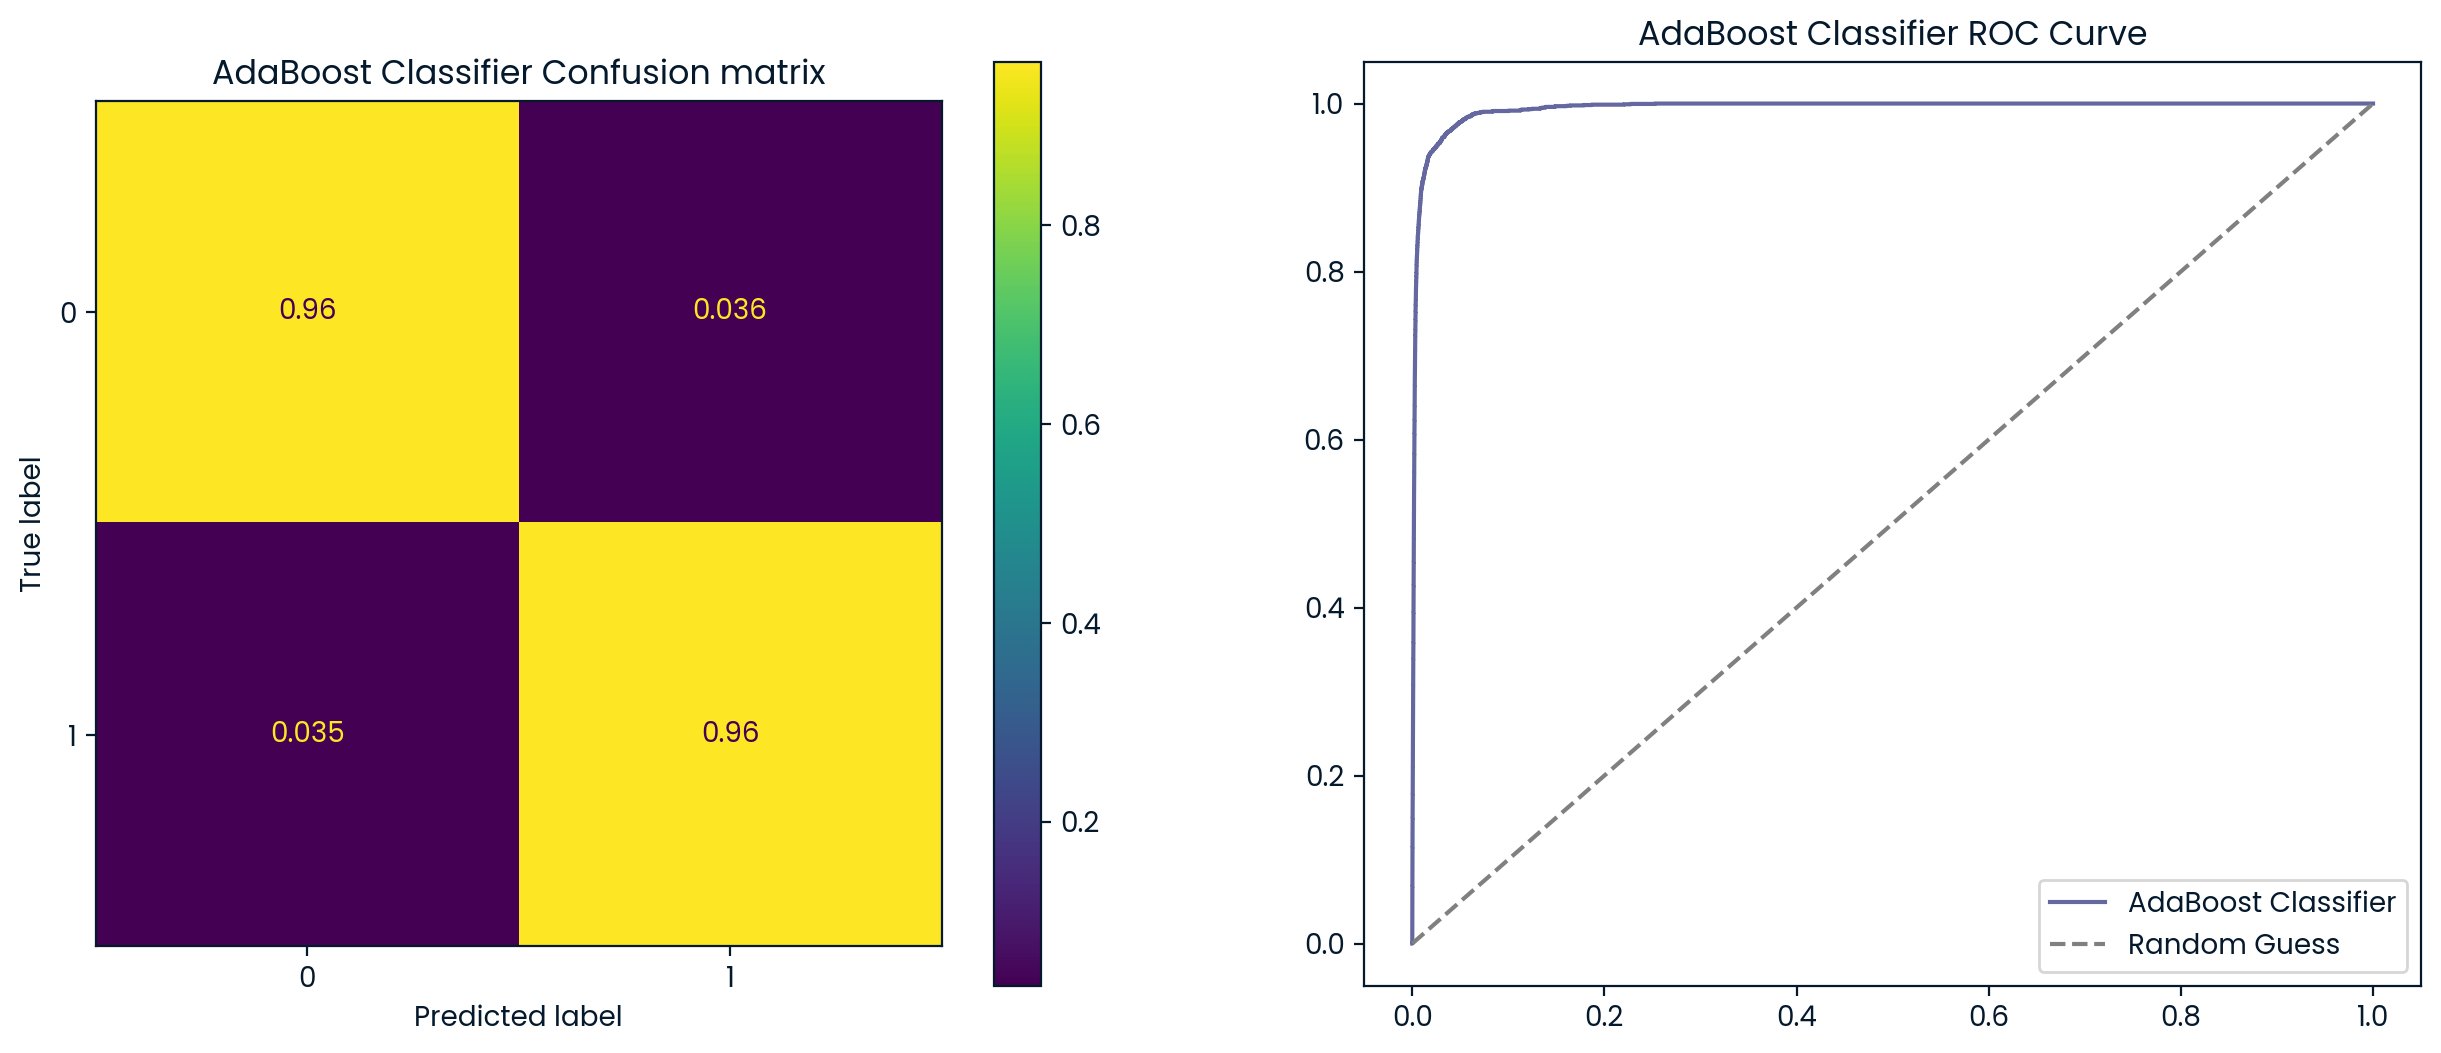

<Figure size 1500x1000 with 0 Axes>

Accuracy 0.96
Precision: 0.14
Recall: 0.96
F1 Score 0.24
AUC: 0.9942333296055067


In [28]:

rfc = RandomForestClassifier(max_depth=3, max_leaf_nodes=13,
                             min_samples_leaf=2, min_samples_split=6,
                             n_jobs=-1)

# Instantiate ada
ada = AdaBoostClassifier(base_estimator=rfc, n_estimators=180, random_state=42)

# Fit ada to the training set
ada.fit(X_train_resampled, y_train_resampled)   

evaluate_model(X_test, y_test, ada, 'AdaBoost Classifier', normalize_matrix='true')

## Evaluating the model on the test set

#### Preparing test data

I will apply the same processing functions and transformations that I applied to the training set on the test set

In [29]:
# Upload test data as a .csv file 
df2 = pd.read_csv('fraudTest.csv', index_col=0)
print(df2.shape)
df2.head()

(555719, 22)


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [30]:
# Selecting relevant columns
df_test = pd.DataFrame(df2[columns_of_interest])


In [31]:
#Examine the target variable (classes)
print(df_test['is_fraud'].value_counts())

0    553574
1      2145
Name: is_fraud, dtype: int64


In [32]:
# Feature engineering to remove redundant features
df_test['age'] = dt.date.today().year-pd.to_datetime(df_test['dob']).dt.year

df_test['trans_day'] = pd.to_datetime(df_test['trans_date_trans_time']).dt.day
df_test['trans_month'] = pd.to_datetime(df_test['trans_date_trans_time']).dt.month
df_test['trans_year'] = pd.to_datetime(df_test['trans_date_trans_time']).dt.year

df_test['cc_num_len'] = df_test['cc_num'].apply(lambda x: len(str(x)))

df_test['gender'] = label_encoder.fit_transform(df_test['gender'])
df_test['category'] = label_encoder.fit_transform(df_test['category'])

df_test.drop(['trans_date_trans_time', 'dob', 'cc_num', 'city', 'state'], inplace=True, axis=1)
print(df_test.shape)
df_test.head()

(555719, 11)


,category,amt,gender,zip,city_pop,is_fraud,age,trans_day,trans_month,trans_year,cc_num_len
0,10,2.86,1,29209,333497,0,56,21,6,2020,16
1,10,29.84,0,84002,302,0,34,21,6,2020,16
2,5,41.28,0,11710,34496,0,54,21,6,2020,16
3,9,60.05,1,32780,54767,0,37,21,6,2020,16
4,13,3.19,1,49632,1126,0,69,21,6,2020,16


In [33]:
X = df_test.drop(['is_fraud'], axis=1)
y = df_test['is_fraud']

#### Evaluate model on test data

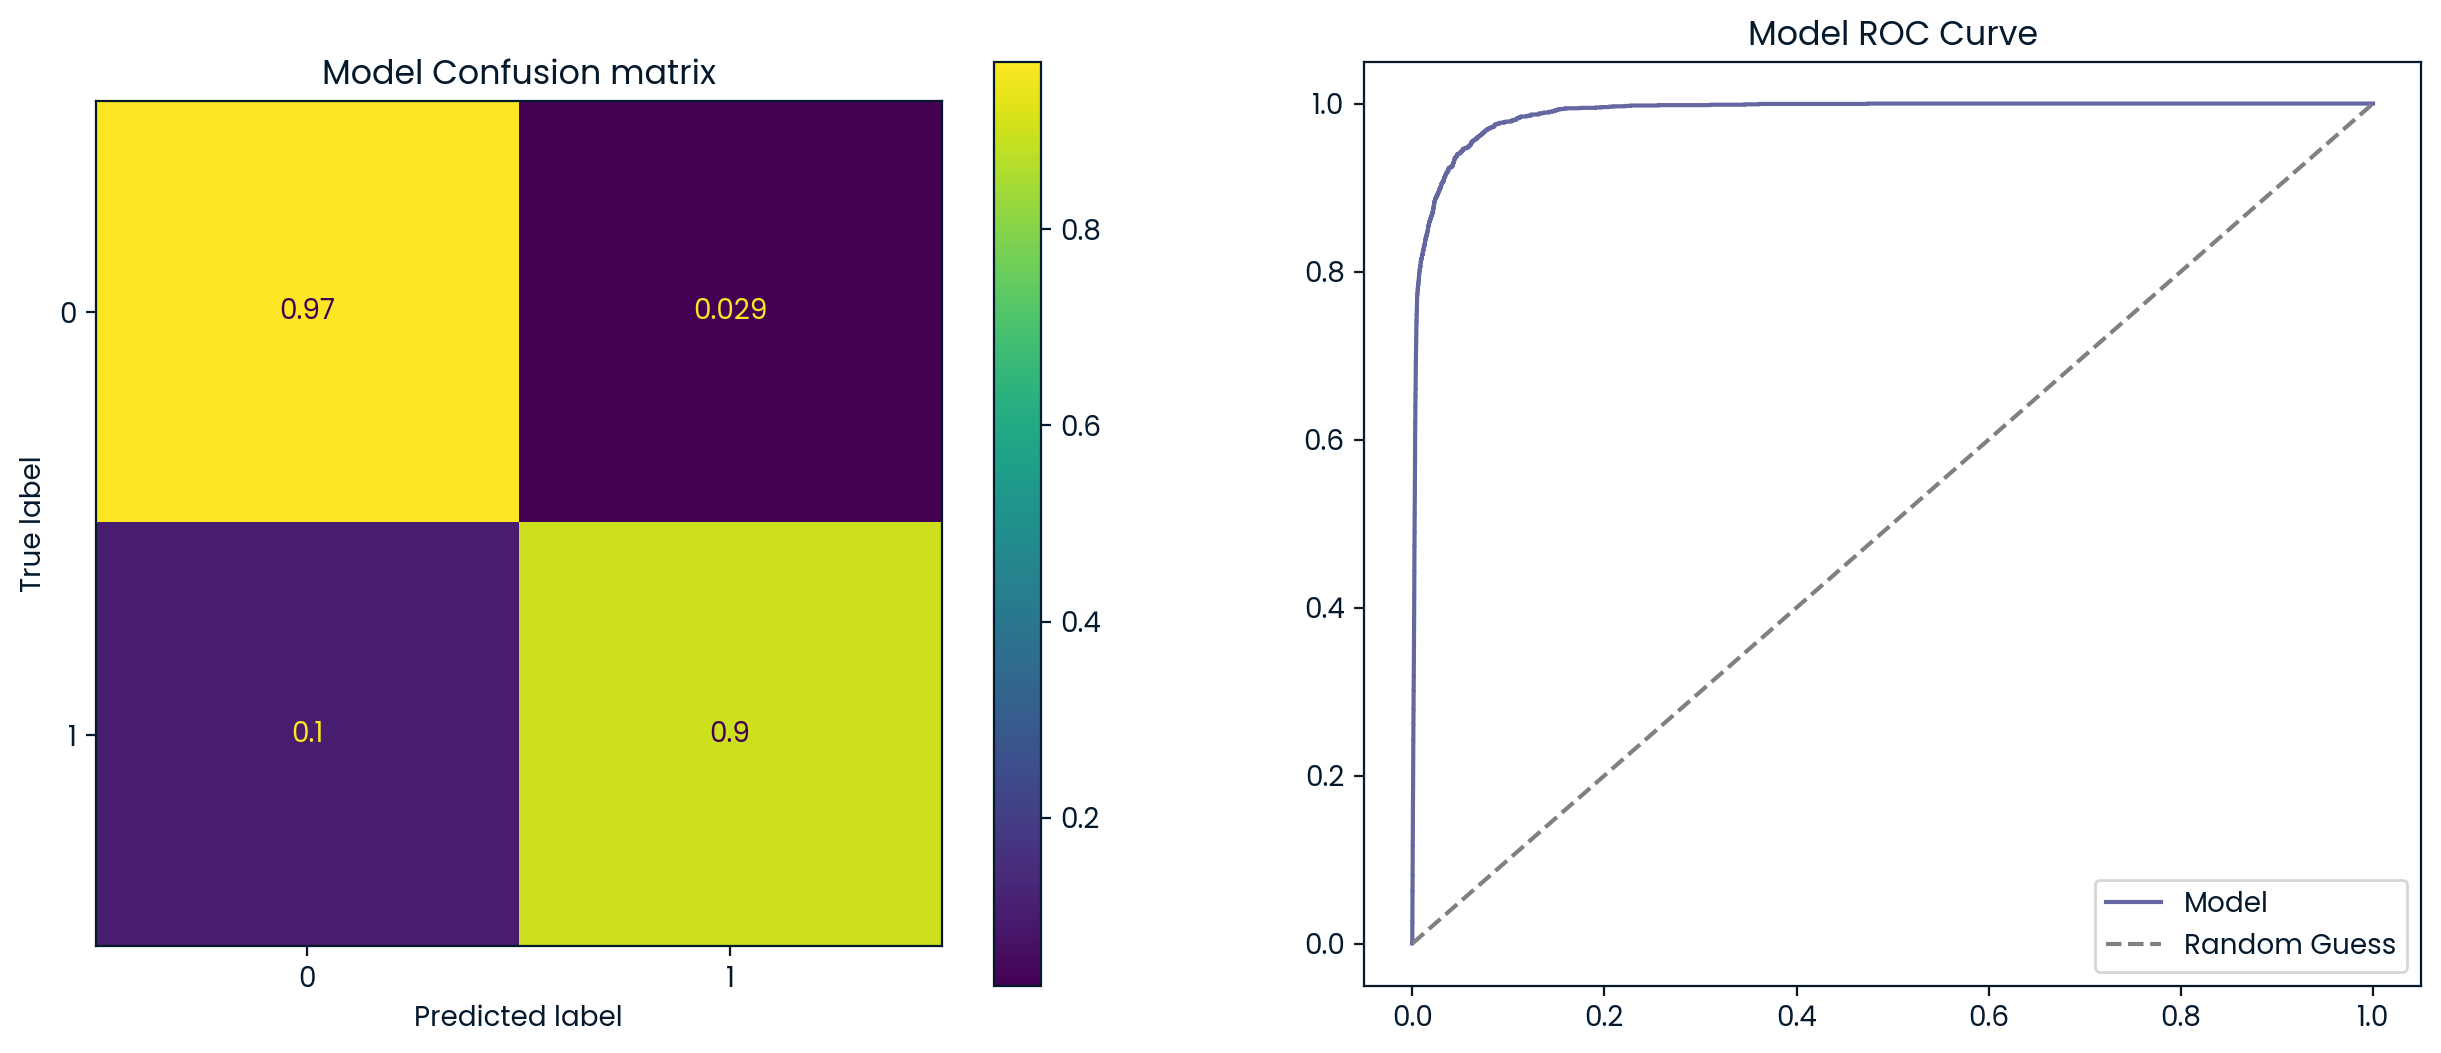

<Figure size 1500x1000 with 0 Axes>

Accuracy 0.97
Precision: 0.11
Recall: 0.9
F1 Score 0.19
AUC: 0.988963922111794


In [34]:
# evaluate_model(X, y, best_model)
evaluate_model(X, y, ada, 'Final Model - ', normalize_matrix='true')

## Conclusion

Trained AdaBoost classifier on training subset with parameters of max_depth=3, max_leaf_nodes=13, min_samples_leaf=3, min_samples_split=4 and n_estimators=300. The average precision, recall, and f1-scores on validation subsets were 0.11, 0.9, and 0.19, respectively. The area under ROC (AUC) was 0.99.

The AdaBoost model demonstrates shows high accuracy, it performs poorly in terms of precision and F1 score, especially considering the class imbalance. The normalized confusion matrix, shows that the model performs well.